In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import numpy as np
import seaborn as sns
import copy
import statistics
import re
import math
import time
from scipy import stats
import json
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels
from collections import Counter
# plt.style.use("seaborn-v0_8")
sns.set_theme(style="white")

## power analysis

In [351]:
# statistical power

# parameters for power analysis
effect = 0.8
alpha = 0.05
power = 0.8
# perform power analysis
# analysis = TTestIndPower()
# result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)

result = statsmodels.stats.power.tt_ind_solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 25.525


In [352]:
#dependent t-test
result = statsmodels.stats.power.tt_solve_power(effect, power=power, nobs=None, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 14.303


In [353]:
# chi_analysis =
chi_result =  statsmodels.stats.power.GofChisquarePower().solve_power(effect_size=effect, nobs=None, alpha=0.05, power=0.8, n_bins=2)
print(chi_result)

12.263847027781765


## Data Preprocessing

In [354]:
response_df = pd.read_csv("XAI_user_study_one_scenario_only_response/XAI_user_study_one_scenario_only_August 28, 2023_12.17.csv", header=0)
# response_df.head(10)
# print(response_df.columns)

qid = []
for i in range(len(response_df.columns)):
    qid.append(list(json.loads(response_df.loc[1][i]).values())[0])

response_df.loc[1] = qid

response_df = response_df[~response_df.Model.isnull()].reset_index(drop=True)

# 6414722de2fa306c0e32ef73 --- failed attention check questions, thus remove
response_df = response_df[response_df.PROLIFIC_PID != "6414722de2fa306c0e32ef73"].reset_index(drop=True)

response_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Columns: 204 entries, StartDate to Highdt4al-dup_DO
dtypes: object(204)
memory usage: 322.1+ KB


In [355]:
response_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Highlr4al_DO,Highlr4al-dup_DO,Highdt1ft_DO,Highdt1ft-dup_DO,Highdt2db_DO,Highdt2db-dup_DO,Highdt3cf_DO,Highdt3cf-dup_DO,Highdt4al_DO,Highdt4al-dup_DO
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,High lr 4 al - Display Order,High lr 4 al - dup - Display Order,High dt 1 ft - Display Order,High dt 1 ft - dup - Display Order,High dt 2 db - Display Order,High dt 2 db - dup - Display Order,High dt 3 cf - Display Order,High dt 3 cf - dup - Display Order,High dt 4 al - Display Order,High dt 4 al - dup - Display Order
1,startDate,endDate,status,ipAddress,progress,duration,finished,recordedDate,_recordId,recipientLastName,...,BL_9Laorz6vXOWvvJY_DO,BL_0DLEHQGUCdeBuWG_DO,BL_816RHHhRepf8QbY_DO,BL_b41yvukRIrDGW8K_DO,BL_5pCqoeXo4X09s6a_DO,BL_0INtcK9h0O5v1Ma_DO,BL_d0amkCvHQRCWaQm_DO,BL_eLNL0AOfAODNS5g_DO,BL_6tUsoD7Bz7VLSRw_DO,BL_e5M98b0zAC7e7mm_DO
2,2023-08-26 03:20:55,2023-08-26 03:27:04,IP Address,146.200.198.240,100,369,True,2023-08-26 03:27:05,R_3qeODFvkpa9V4Lq,NaN,...,NaN,Q266|ct-l4|confidence-l4ct|true-l4|confidence-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-08-26 03:20:01,2023-08-26 03:27:08,IP Address,86.180.7.204,100,426,True,2023-08-26 03:27:09,R_2WOxzDbNoDNAHCd,NaN,...,NaN,NaN,high-dt-1-desc|false-d1|confidence-d1tf|ct-d1|...,NaN,high-dt-2-desc|false-d2|confidence-d2tf|ct-d2|...,NaN,Q99|false-d3|confidence-d3tf|ct-d3|confidence-...,NaN,Q106|false-d4|confidence-d4tf|ct-d4|confidence...,NaN
4,2023-08-26 03:20:12,2023-08-26 03:27:23,IP Address,82.23.119.233,100,431,True,2023-08-26 03:27:24,R_22nbBLMDTzvx7tw,NaN,...,Q91|false-l4|confidence-l4tf|ct-l4|confidence-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [356]:
# average duration
# completion_time = list(map(int, response_df["Q_TotalDuration"][2:].to_list()))
completion_time = pd.to_numeric(response_df["Q_TotalDuration"][2:])
avg_duration = time.strftime('%H:%M:%S', time.gmtime(completion_time.mean()))
max_duration = time.strftime('%H:%M:%S', time.gmtime(completion_time.max()))
min_duration = time.strftime('%H:%M:%S', time.gmtime(completion_time.min()))

print("Average completion time is: {}s, max time is: {}s, min time is: {}s".format(avg_duration, max_duration, min_duration))
# print(response_df.drop(columns=["PageNumber"]))


Average completion time is: 00:13:21s, max time is: 00:55:23s, min time is: 00:04:43s


In [357]:
# get Logistic regression response

lr_response = response_df.loc[response_df["Model"]=="LR"]
print("Number of responses for logistic regression:", lr_response.shape[0])

# get decision tree response
dt_response = response_df.loc[response_df["Model"]=="DT"]
print("Number of responses for decision tree:", dt_response.shape[0])

Number of responses for logistic regression: 101
Number of responses for decision tree: 99


In [358]:
# graph literacy test
# average result, average completion time
graph_q1_answer = 25

graph_q2_answer ={
    "They are equal": 1,
    "Crosicol": 0,
    "Hertinol": 0,
    "Can't say": 0
}

graph_q3_answer = 20

graph_q4_answer = {
    "Can't say": 1,
    "Apsoriatin": 0,
    "Nopsorian": 0,
    "They are equal": 0,
}

# pd.to_numeric(response_df["g1_4"][2:])
g1_numbers = []
for i in range(response_df.shape[0]-2):
    g1_number = re.findall(r'\d+\.\d+|\d+',response_df["g1_4"][2:].tolist()[i])
    g1_numbers.append(g1_number[0])

g3_numbers = []
for i in range(response_df.shape[0]-2):
    g3_number = re.findall(r'\d+\.\d+|\d+',response_df["g3_1"][2:].tolist()[i])
    g3_numbers.append(g3_number[0])

g1_response_values = pd.to_numeric(g1_numbers)
g3_response_values = pd.to_numeric(g3_numbers)

g1_response = np.where((g1_response_values<=26) & (g1_response_values>=24), 1, 0)
g3_response = np.where(g3_response_values==graph_q3_answer, 1, 0)
g2_response = response_df["g2"][2:].map(graph_q2_answer).reset_index(drop=True)
g4_response = response_df["g4"][2:].map(graph_q4_answer).reset_index(drop=True)
sgl_duration = pd.to_numeric(response_df["Q5_Page Submit"][2:]).reset_index(drop=True)
sgl_response = pd.DataFrame({"g1":g1_response, "g2":g2_response, "g3":g3_response, "g4":g4_response, "duration":sgl_duration})
sgl_response["avg_score"] = sgl_response.iloc[:,:4].sum(axis=1)
# print(sgl_response)

avg_duration = time.strftime('%H:%M:%S', time.gmtime(sgl_response["duration"].mean()))
print("Average time on graph test:", avg_duration)

print("Average short graph literacy score is:", sgl_response["avg_score"].mean())
print("SD is:", sgl_response["avg_score"].std())
# print(sgl_response["avg_score"].min())

Average time on graph test: 00:02:43
Average short graph literacy score is: 2.455
SD is: 1.059996681515617


In [359]:
# basic demographic information analysis

# age
print("age overview:", response_df["i1"][2:].value_counts(sort=False))
# gender
print("gender overview:", response_df["i2"][2:].value_counts(sort=False))
# english 
print("english overview:", response_df["i3"][2:].value_counts(sort=False))
# education
print("education overview:", response_df["i4"][2:].value_counts(sort=False))


age overview: i1
35-44 years old    44
45-54 years old    31
18-24 years old    37
25-34 years old    49
55-64 years old    22
65+ years old      17
Name: count, dtype: int64
gender overview: i2
Female                       99
Male                         96
Non-binary / third gender     5
Name: count, dtype: int64
english overview: i3
Mastery               134
Advanced               46
Intermediate            7
Upper-Intermediate     12
Pre-Intermediate        1
Name: count, dtype: int64
education overview: i4
Bachelor's degree                                                         86
Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS etc.)      42
High school graduate (high school diploma or equivalent including GED)    38
College degree                                                            30
Less than high school degree                                               4
Name: count, dtype: int64


In [360]:
# stem
print("stem overview:", response_df["i5"][2:].value_counts(sort=False))
# ml_knowledge
print("ml-knowledge overview:", response_df["i6"][2:].value_counts(sort=False))
# experience
print("prior experience overview:", response_df["i7"][2:].value_counts(sort=False))

stem overview: i5
Yes, my education and/or employment is related to STEM field     61
No                                                              139
Name: count, dtype: int64
ml-knowledge overview: i6
No knowledge                                                                           95
Negligible knowledge: I know basic concepts in ML, but have never applied them         63
Some knowledge: I have used ML algorithms before                                       35
Moderate knowledge: I apply ML algorithms somewhat frequently in my work or leisure     7
Name: count, dtype: int64
prior experience overview: i7
None (0)                         125
A few (roughly 1-5)               69
A lot (probably more than 15)      2
A fair amount (around 6-15)        4
Name: count, dtype: int64


In [361]:
# examine attention check question correctness

# l1
att_check_q1_answer = {
    "Diabetes": 1,
    "Dental Care": 0,
    "Deafness": 0,
    "Digestive Disease": 0
}

# l3
att_check_q3_answer = {
    "Insulin": 1,
    "Air Pollution": 0,
    "Smoking": 0,
    "Vitamin Supplements": 0
}

# l4
att_check_q4_answer = {
    "Smoking": 0,
    "Alcohol Consumption": 0,
    "Blood Pressure": 1,
    "Sweat Rate": 0
}

for i in [1,3,4]:
    # print(i)
    response_df["att-l{}".format(i)] = response_df["att-l{}".format(i)].fillna(response_df["att-l{}.1".format(i)])
    response_df["att-l{}".format(i)] = response_df["att-l{}".format(i)].fillna(response_df["att-d{}".format(i)])
    response_df["att-l{}".format(i)] = response_df["att-l{}".format(i)].fillna(response_df["att-d{}.1".format(i)])


    response_df.drop(["att-l{}.1".format(i)], axis=1, inplace=True)
    response_df.drop(["att-d{}".format(i)], axis=1, inplace=True)
    response_df.drop(["att-d{}.1".format(i)], axis=1, inplace=True)


def mark_attention_check_question(att_id):
    att_col_name = "att-l{}".format(att_id)
    att_response = response_df[att_col_name][2:].map(globals()["att_check_q{}_answer".format(att_id)]).reset_index(drop=True)
    return att_response

att_1_score = mark_attention_check_question(1)
att_2_score = mark_attention_check_question(3)
att_3_score = mark_attention_check_question(4)

att_check_response = pd.DataFrame({"att1":att_1_score, "att2":att_2_score, "att3":att_3_score})
id_fail_attention = att_check_response[att_check_response.sum(axis=1) < 3]

print(id_fail_attention)

     att1  att2  att3
10      1     1     0
38      1     0     1
67      1     1     0
155     1     0     0
176     1     1     0
184     1     0     1
197     0     1     1


In [362]:
# Participants who failed part of attention check
print(response_df[["att-l4"]].iloc[6, :])
print(response_df.loc[12, "PROLIFIC_PID"])

print(response_df[["att-l3"]].iloc[6, :])
print(response_df.loc[40, "PROLIFIC_PID"])

print(response_df[["att-l1"]].iloc[47, :])
print(response_df.loc[40, "PROLIFIC_PID"])


att-l4    Blood Pressure
Name: 6, dtype: object
62f2206882d24362ec5ea465
att-l3    Insulin
Name: 6, dtype: object
56eb00e515ef53000b46726c
att-l1    Diabetes
Name: 47, dtype: object
56eb00e515ef53000b46726c


In [363]:
response_df.columns[15:50]

Index(['DistributionChannel', 'UserLanguage', 'Q_RecaptchaScore',
       'consent question', 'Q300_First Click', 'Q300_Last Click',
       'Q300_Page Submit', 'Q300_Click Count', 'true-l1', 'false-l1',
       'confidence-l1tf_11', 'ct-l1', 'confidence-l1ct_11', 'att-l1',
       'att-l1_DO', 'contentment-l1_1', 'contentment-l1_2', 'ct-l1.1',
       'confidence-l1ct_11.1', 'true-l1.1', 'false-l1.1',
       'confidence-l1tf_11.1', 'att-l1_DO.1', 'contentment-l1_1.1',
       'contentment-l1_2.1', 'true-l2', 'false-l2', 'confidence-l2tf_1',
       'ct-l2', 'confidence-l2ct_1', 'contentment-l2_1', 'contentment-l2_2',
       'ct-l2.1', 'confidence-l2ct_1.1', 'true-l2.1'],
      dtype='object')

In [11]:
## True False assertion accuracy rate

def check_accuracy(exp_id, asser_type, response_df):
    answers = response_df[f"{asser_type}-l{exp_id}"].dropna().tolist()[2:] + response_df[f"{asser_type}-l{exp_id}.1"].dropna().tolist()[2:] + response_df[f"{asser_type}-d{exp_id}"].dropna().tolist()[2:] + response_df[f"{asser_type}-d{exp_id}.1"].dropna().tolist()[2:]
    if asser_type == "true":
        correct_count = answers.count("True")
    elif asser_type == "false":
        correct_count = answers.count("False")
    total_count = len(answers)
    acc = correct_count/total_count
    return acc
all_true_acc = []
all_false_acc = []

for exp_id in range(1,5):
    all_true_acc.append(check_accuracy(exp_id, "true", response_df))
    all_false_acc.append(check_accuracy(exp_id, "false", response_df))

print(all_true_acc)
print(all_false_acc)

[0.801980198019802, 0.91, 0.49514563106796117, 0.5757575757575758]
[0.5454545454545454, 0.79, 0.5567010309278351, 0.42574257425742573]


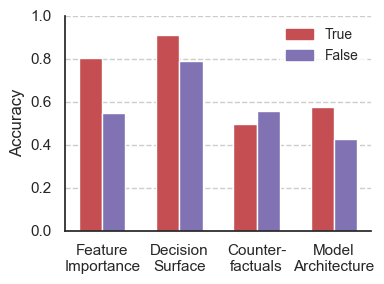

In [12]:
# Bar width
bar_width = 0.3
categories = ["Feature\nImportance", "Decision\nSurface", "Counter-\nfactuals", "Model\nArchitecture"]

# Positions of the bars on the x-axis
r1 = range(len(all_true_acc))
r2 = [x + bar_width for x in r1]

fig, ax = plt.subplots(figsize=(4, 3))
plt.bar(r1, all_true_acc, color=sns.color_palette()[3], width=bar_width, edgecolor='white', label='True')
plt.bar(r2, all_false_acc, color=sns.color_palette()[4], width=bar_width, edgecolor='white', label='False')

plt.xticks([r + bar_width/2 for r in range(len(all_true_acc))], categories)
plt.ylabel('Accuracy')

plt.ylim(0,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linestyle="--", axis="y", zorder=-1)

patches = [mpl.patches.Patch(color=sns.color_palette()[i+3], label=t) for i,t in enumerate(["True","False"])]
ax.legend(handles=patches, loc="upper right", fontsize=10, edgecolor="white") 

plt.tight_layout()
# plt.savefig("acc_true_false_questions.pdf", dpi=300, transparent=True)
plt.show()


In [13]:
# calculate how many times a user select cannot tell
# for those low confidence, how many of them select cannot tell

ct_counts=[]
for index, row in response_df[2:].iterrows():
    counts = row.tolist().count("Cannot infer from the explanation")
    ct_counts.append(counts)

print("average cf counts:",np.mean(ct_counts))
# print(np.std(ct_counts))


average cf counts: 1.875


In [14]:
# calculate average confidence of a person
confidence_columns = response_df.filter(like="confidence").columns

low_conf_ct_counts=[]
avg_conf_level = []

for index, row in response_df[2:].iterrows():
    confidence_values = response_df.loc[index, confidence_columns].dropna().astype(int).tolist()
    if np.mean(confidence_values)>=80 and np.mean(confidence_values)<=100:
        counts = row.tolist().count("Cannot infer from the explanation")
        low_conf_ct_counts.append(counts)
        avg_conf_level.append(np.mean(confidence_values))

print(len(low_conf_ct_counts))
print(np.mean(low_conf_ct_counts))
print(np.mean(avg_conf_level))

51
1.8431372549019607
86.31372549019608


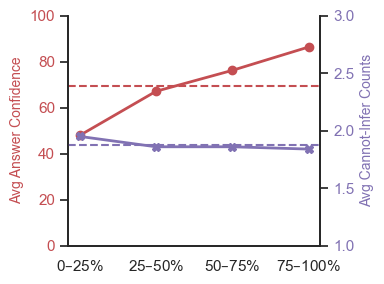

In [20]:
avg_conf_level = [47.92, 67.08, 76.17, 86.31]  # average confidence level for 4 groups
avg_ct_count = [1.95, 1.86, 1.86, 1.84]       # average cf counts for each group
groups = [r"0$\endash$25%", r'25$\endash$50%', r'50$\endash$75%', r'75$\endash$100%']

fig, ax1 = plt.subplots(figsize=(4, 3))
blue = sns.color_palette()[3]
green = sns.color_palette()[4]
# Plot avg_conf_level on the left y-axis
ax1.plot(groups, avg_conf_level, color=blue,marker="o", label='Avg Answer Confidence', linewidth=2)
ax1.set_ylabel('Avg Answer Confidence', color=blue, fontsize=10)
ax1.tick_params(axis='y', labelcolor=blue,labelsize=11)
ax1.set_ylim(0,100)
ax1.spines['top'].set_visible(False)

# Create a second y-axis for avg_ct_count
ax2 = ax1.twinx()
ax2.plot(groups, avg_ct_count, color=green, marker="X", label='Avg Cannot-Infer Counts', linewidth=2)
ax2.set_ylabel('Avg Cannot-Infer Counts', color=green, fontsize=10)
ax2.tick_params(axis='y', labelcolor=green,labelsize=11)
ax2.set_ylim(1,3)

# ax1.grid(linestyle="--", axis="x", zorder=-1)

ax1.axhline(y=69.52, linestyle="--", color=blue, zorder=-2)  # average answer confidence
ax2.axhline(y=1.875, linestyle="--", color=green, zorder=-2)  # average ct count

ax2.spines['top'].set_visible(False)
plt.tight_layout()
# plt.savefig("conf_vs_ct_count.pdf", dpi=300, transparent=True)
plt.show()


In [10]:
# rating on each explanation

# For LR
def check_qid_index(qid):
    return np.where(response_df.loc[1]==qid)[0][0]

def merge_rating(primary_column, secondary_column, response_df):
    # print(response_df[secondary_column])
    response_df[primary_column] = response_df[primary_column].fillna(response_df[secondary_column])
    response_df.drop([secondary_column], axis=1, inplace=True)
    

rating_pairs = [["contentment-l1_1", "contentment-l1_1.1"], ["contentment-l1_2", "contentment-l1_2.1"],
                ["contentment-l2_1", "contentment-l2_1.1"], ["contentment-l2_2", "contentment-l2_2.1"],
                ["contentment-l3_1", "contentment-l3_1.1"], ["contentment-l3_2", "contentment-l3_2.1"],
                ["contentment-l4_1", "contentment-l4_1.1"], ["contentment-l4_2", "contentment-l4_2.1"],
                ["contentment-d1_1", "contentment-d1_1.1"], ["contentment-d1_2", "contentment-d1_2.1"],
                ["contentment-d2_1", "contentment-d2_1.1"], ["contentment-d2_2", "contentment-d2_2.1"],
                ["contentment-d3_1", "contentment-d3_1.1"], ["contentment-d3_2", "contentment-d3_2.1"],
                ["contentment-d4_1", "contentment-d4_1.1"], ["contentment-d4_2", "contentment-d4_2.1"]]

for pair in rating_pairs:
    # print(pair)
    merge_rating(pair[0], pair[1], response_df)

rating_score = {
    # float("nan"): 0,
    "Strongly disagree": 1,
    "Disagree": 2,
    "Somewhat disagree": 3,
    "Neither agree nor disagree": 4,
    "Somewhat agree": 5,
    "Agree": 6,
    "Strongly agree": 7
}

def convert_rating(response_df):
    for i in range(1,5):
        column_name = "contentment-l{}_1".format(i)
        detailed_column_name = "contentment-l{}_2".format(i)
        response_df[column_name][2:] = response_df[column_name][2:].map(rating_score).reset_index(drop=True)
        response_df[detailed_column_name][2:] = response_df[detailed_column_name][2:].map(rating_score).reset_index(drop=True)
    for i in range(1,5):
        column_name = "contentment-d{}_1".format(i)
        detailed_column_name = "contentment-d{}_2".format(i)
        response_df[column_name][2:] = response_df[column_name][2:].map(rating_score).reset_index(drop=True)
        response_df[detailed_column_name][2:] = response_df[detailed_column_name][2:].map(rating_score).reset_index(drop=True)

convert_rating(response_df)


In [364]:
l1_c_response = response_df["contentment-l1_1"][2:]
l2_c_response = response_df["contentment-l2_1"][2:]
l3_c_response = response_df["contentment-l3_1"][2:]
l4_c_response = response_df["contentment-l4_1"][2:]

l1_s_response = response_df["contentment-l1_2"][2:]
l2_s_response = response_df["contentment-l2_2"][2:]
l3_s_response = response_df["contentment-l3_2"][2:]
l4_s_response = response_df["contentment-l4_2"][2:]

In [365]:
d1_c_response = response_df["contentment-d1_1"][2:]
d2_c_response = response_df["contentment-d2_1"][2:]
d3_c_response = response_df["contentment-d3_1"][2:]
d4_c_response = response_df["contentment-d4_1"][2:]

d1_s_response = response_df["contentment-d1_2"][2:]
d2_s_response = response_df["contentment-d2_2"][2:]
d3_s_response = response_df["contentment-d3_2"][2:]
d4_s_response = response_df["contentment-d4_2"][2:]

In [366]:
## Check if the contentment rating with-in subject is significant (using Repeated Measures ANOVA)
# combine contentment rating for LR explanations
contentment_df_l1 = pd.DataFrame({"user_id": range(len(l1_c_response)), "exp_id": "e1", "c_rating": l1_c_response})
contentment_df_l2 = pd.DataFrame({"user_id": range(len(l2_c_response)), "exp_id": "e2", "c_rating": l2_c_response})
contentment_df_l3 = pd.DataFrame({"user_id": range(len(l3_c_response)), "exp_id": "e3", "c_rating": l3_c_response})
contentment_df_l4 = pd.DataFrame({"user_id": range(len(l4_c_response)), "exp_id": "e4", "c_rating": l4_c_response})

contentment_lr_df = pd.concat([contentment_df_l1, contentment_df_l2, contentment_df_l3, contentment_df_l4], axis=0, ignore_index=True).dropna(subset=["c_rating"])
print(contentment_lr_df.shape)

print(AnovaRM(data=contentment_lr_df, depvar="c_rating", subject="user_id", within=["exp_id"]).fit())

(404, 3)
                Anova
       F Value  Num DF  Den DF  Pr > F
--------------------------------------
exp_id 101.0005 3.0000 300.0000 0.0000



In [367]:
contentment_df_d1 = pd.DataFrame({"user_id": range(len(d1_c_response)), "exp_id": "e1", "c_rating": d1_c_response})
contentment_df_d2 = pd.DataFrame({"user_id": range(len(d2_c_response)), "exp_id": "e2", "c_rating": d2_c_response})
contentment_df_d3 = pd.DataFrame({"user_id": range(len(d3_c_response)), "exp_id": "e3", "c_rating": d3_c_response})
contentment_df_d4 = pd.DataFrame({"user_id": range(len(d4_c_response)), "exp_id": "e4", "c_rating": d4_c_response})

contentment_dt_df = pd.concat([contentment_df_d1, contentment_df_d2, contentment_df_d3, contentment_df_d4], axis=0, ignore_index=True).dropna(subset=["c_rating"])
print(contentment_dt_df.shape)

print(AnovaRM(data=contentment_dt_df, depvar="c_rating", subject="user_id", within=["exp_id"]).fit())

(396, 3)
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
exp_id 35.7927 3.0000 294.0000 0.0000



In [368]:
contentment_lr_df = pd.concat([contentment_df_l1.iloc[:-2, :], contentment_df_l2.iloc[:-2, :], contentment_df_l3.iloc[:-2, :], contentment_df_l4.iloc[:-2, :]], axis=0, ignore_index=True).dropna(subset=["c_rating"])

contentment_dt_df = pd.concat([contentment_df_d1, contentment_df_d2, contentment_df_d3, contentment_df_d4], axis=0, ignore_index=True).dropna(subset=["c_rating"])
contentment_df = pd.concat([contentment_lr_df, contentment_dt_df], ignore_index=True )
print(contentment_df.shape)

print(AnovaRM(data=contentment_df, depvar="c_rating", subject="user_id", within=["exp_id"]).fit().summary())

(792, 3)
                Anova
       F Value  Num DF  Den DF  Pr > F
--------------------------------------
exp_id 121.6130 3.0000 591.0000 0.0000



In [369]:
detail_df_l1 = pd.DataFrame({"user_id": range(len(l1_s_response)), "exp_id": "e1", "s_rating": l1_s_response})
detail_df_l2 = pd.DataFrame({"user_id": range(len(l2_s_response)), "exp_id": "e2", "s_rating": l2_s_response})
detail_df_l3 = pd.DataFrame({"user_id": range(len(l3_s_response)), "exp_id": "e3", "s_rating": l3_s_response})
detail_df_l4 = pd.DataFrame({"user_id": range(len(l4_s_response)), "exp_id": "e4", "s_rating": l4_s_response})

detail_lr_df = pd.concat([detail_df_l1, detail_df_l2, detail_df_l3, detail_df_l4], axis=0, ignore_index=True).dropna(subset=["s_rating"])
print(detail_lr_df.shape)

print(AnovaRM(data=detail_lr_df, depvar="s_rating", subject="user_id", within=["exp_id"]).fit())

(404, 3)
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
exp_id 13.5424 3.0000 300.0000 0.0000



In [370]:
detail_df_d1 = pd.DataFrame({"user_id": range(len(d1_s_response)), "exp_id": "e1", "s_rating": d1_s_response})
detail_df_d2 = pd.DataFrame({"user_id": range(len(d2_s_response)), "exp_id": "e2", "s_rating": d2_s_response})
detail_df_d3 = pd.DataFrame({"user_id": range(len(d3_s_response)), "exp_id": "e3", "s_rating": d3_s_response})
detail_df_d4 = pd.DataFrame({"user_id": range(len(d4_s_response)), "exp_id": "e4", "s_rating": d4_s_response})

detail_dt_df = pd.concat([detail_df_d1, detail_df_d2, detail_df_d3, detail_df_d4], axis=0, ignore_index=True).dropna(subset=["s_rating"])
print(detail_dt_df.shape)

print(AnovaRM(data=detail_dt_df, depvar="s_rating", subject="user_id", within=["exp_id"]).fit())

(396, 3)
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
exp_id 15.1008 3.0000 294.0000 0.0000



In [371]:
detail_lr_df = pd.concat([detail_df_l1.iloc[:-2, :], detail_df_l2.iloc[:-2, :], detail_df_l3.iloc[:-2, :], detail_df_l4.iloc[:-2, :]], axis=0, ignore_index=True).dropna(subset=["s_rating"])

detail_dt_df = pd.concat([detail_df_d1, detail_df_d2, detail_df_d3, detail_df_d4], axis=0, ignore_index=True).dropna(subset=["s_rating"])
detail_df = pd.concat([detail_lr_df, detail_dt_df], ignore_index=True)
print(detail_df.shape)

print(AnovaRM(data=detail_df, depvar="s_rating", subject="user_id", within=["exp_id"]).fit().summary())

(792, 3)
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
exp_id 26.8978 3.0000 591.0000 0.0000



In [372]:
# Check if contentment rating between LR and DT is significant (using independent T-test?)

response_df["avg_lr_contentment"] = response_df.loc[2:, ["contentment-l1_1", "contentment-l2_1", "contentment-l3_1", "contentment-l4_1"]].mean(axis=1)
response_df["avg_dt_contentment"] = response_df.loc[2:, ["contentment-d1_1", "contentment-d2_1", "contentment-d3_1", "contentment-d4_1"]].mean(axis=1)

# print(response_df["avg_lr_contentment"].fillna(response_df["avg_dt_contentment"]))
# print(response_df["avg_lr_contentment"].dropna().tolist())

print("differ in average contentment between LR and DT")
print(stats.ttest_ind(response_df["avg_lr_contentment"].dropna().tolist(), response_df["avg_dt_contentment"].dropna().tolist()))

# check if contentment between l4 and d4 is significant (independent T-test)
print("\ndiffer in contentment between LR's model and DT's model explanation")
print(stats.ttest_ind(response_df["contentment-l4_1"][2:].dropna().tolist(), response_df["contentment-d4_1"][2:].dropna().tolist()))

# print(exp1_c[2:].mean())

differ in average contentment between LR and DT
Ttest_indResult(statistic=-0.8634787854160462, pvalue=0.38891903309243714)

differ in contentment between LR's model and DT's model explanation
Ttest_indResult(statistic=-4.434564213739064, pvalue=1.5281689220655504e-05)


In [373]:
# rename
response_df.rename(columns={
    "confidence-l1tf_11": "confidence-l1tf_1",
    "confidence-l1ct_11": "confidence-l1ct_1",
    "confidence-l1tf_11.1": "confidence-l1tf_1.1",
    "confidence-l1ct_11.1": "confidence-l1ct_1.1"}, inplace=True)

In [374]:
# process comprehension question answer

# combine "true-l1 & true-l1.1", "false-l1"&"false-l1.1", etc...

for t in ["l", "d"]:
    for i in range(1,5):
        true_col_name = "true-{}{}".format(t,i)
        false_col_name = "false-{}{}".format(t, i)
        conf_tf_col_name = "confidence-{}{}tf_1".format(t, i)
        ct_col_name = "ct-{}{}".format(t, i)
        conf_ct_col_name = "confidence-{}{}ct_1".format(t, i)
        for name in [true_col_name, false_col_name, conf_tf_col_name, ct_col_name, conf_ct_col_name]:
            merge_rating(name, "{}.1".format(name), response_df)


In [375]:
# calculate T/F and C/T score per person

def mark_tf_answer(exp_id):
    true_col_name = "true-{}".format(exp_id)
    false_col_name = "false-{}".format(exp_id)
    tf_correct_uid = np.where((response_df[true_col_name][2:].str.upper()=="TRUE")| (response_df[false_col_name][2:].str.upper()=="FALSE"), 1, 0)
    tf_nan_uid = np.where((response_df[true_col_name][2:].isnull())& (response_df[false_col_name][2:].isnull()), np.nan, 1)  
    tf_score = tf_correct_uid * tf_nan_uid
    return tf_score

def mark_ct_answer(exp_id):
    ct_col_name = "ct-{}".format(exp_id)
    ct_correct_uid = np.where((response_df[ct_col_name][2:].str.upper()=="CANNOT INFER FROM THE EXPLANATION"), 1, 0)
    ct_nan_uid = np.where(response_df[ct_col_name][2:].isnull(), np.nan, 1)
    ct_score = ct_correct_uid * ct_nan_uid
    return ct_score


l1_ct_score = mark_ct_answer("l1")
print(l1_ct_score)

l2_ct_score = mark_ct_answer("l2")
print(l2_ct_score)
l3_ct_score = mark_ct_answer("l3")
print(l3_ct_score)
l4_ct_score = mark_ct_answer("l4")
print(l4_ct_score)

[ 0. nan  1.  0. nan  1. nan nan nan  0. nan  0.  0.  0. nan  1. nan  1.
  1. nan  0.  1.  0. nan  0.  0. nan  0. nan  1. nan nan  0.  0. nan nan
 nan nan nan  0. nan  0.  0. nan nan nan  1. nan  0. nan  0. nan nan  0.
  0.  0.  0.  0. nan  0. nan  1. nan  0.  0. nan nan  0.  0. nan  1. nan
 nan  1.  0. nan nan nan nan  0. nan  0. nan  0.  0. nan  0. nan nan nan
  0. nan  0.  0.  0.  0. nan  0.  0. nan nan nan  1.  0. nan nan nan nan
  1. nan  0.  0. nan nan nan  0. nan nan nan  0. nan nan nan  0.  0.  0.
 nan  0.  1. nan nan nan  1. nan nan  1.  0. nan nan nan  1.  0.  0.  0.
 nan  0.  1.  1.  0. nan  0. nan  0.  0. nan  0. nan  0. nan nan nan nan
  0.  1.  0.  1.  0. nan  1. nan  0. nan nan nan  0. nan nan  0.  0.  0.
 nan nan nan nan nan  0.  1.  0. nan nan  0.  0. nan  0. nan  0.  1. nan
  0.  0.]
[ 1. nan  1.  0. nan  0. nan nan nan  0. nan  0.  0.  0. nan  1. nan  0.
  0. nan  0.  1.  1. nan  0.  0. nan  0. nan  0. nan nan  0.  0. nan nan
 nan nan nan  0. nan  1.  0. nan nan nan 

In [376]:
d1_tf_score = mark_tf_answer("d1")
print(d1_tf_score)

d2_tf_score = mark_tf_answer("d2")
print(d2_tf_score)
d3_tf_score = mark_tf_answer("d3")
print(d3_tf_score)
d4_tf_score = mark_tf_answer("d4")
print(d4_tf_score)

d1_ct_score = mark_ct_answer("d1")
print(d1_ct_score)

d2_ct_score = mark_ct_answer("d2")
print(d2_ct_score)
d3_ct_score = mark_ct_answer("d3")
print(d3_ct_score)
d4_ct_score = mark_ct_answer("d4")
print(d4_ct_score)

[nan  1. nan nan  1. nan  1.  1.  0. nan  0. nan nan nan  1. nan  1. nan
 nan  1. nan nan nan  1. nan nan  0. nan  1. nan  1.  0. nan nan  1.  1.
  1.  1.  1. nan  1. nan nan  1.  0.  0. nan  0. nan  1. nan  0.  1. nan
 nan nan nan nan  1. nan  1. nan  1. nan nan  0.  0. nan nan  0. nan  0.
  0. nan nan  1.  1.  1.  1. nan  0. nan  0. nan nan  0. nan  0.  1.  1.
 nan  0. nan nan nan nan  0. nan nan  0.  0.  1. nan nan  1.  0.  1.  0.
 nan  0. nan nan  1.  0.  1. nan  1.  1.  0. nan  1.  0.  0. nan nan nan
  0. nan nan  1.  1.  1. nan  0.  0. nan nan  1.  1.  0. nan nan nan nan
  1. nan nan nan nan  0. nan  1. nan nan  1. nan  1. nan  0.  1.  1.  1.
 nan nan nan nan nan  0. nan  1. nan  0.  1.  1. nan  1.  1. nan nan nan
  1.  1.  1.  1.  1. nan nan nan  0.  0. nan nan  1. nan  1. nan nan  1.
 nan nan]
[nan  1. nan nan  1. nan  1.  1.  1. nan  0. nan nan nan  1. nan  1. nan
 nan  1. nan nan nan  1. nan nan  0. nan  1. nan  1.  1. nan nan  1.  1.
  1.  0.  1. nan  1. nan nan  1.  1.  1. 

In [377]:
# i1
age = {
    "18-24 years old": 1,
    "25-34 years old": 2,
    "35-44 years old": 2,
    "45-54 years old": 3,
    "55-64 years old": 3,
    "65+ years old": 3
}

#i2
gender = {
    "Male": 1,
    "Female": 2,
    "Prefer to self-describe": 3,
    "Prefer not to say": 3,
    "Non-binary / third gender": 3
}

#i4
education = {
    "Less than high school degree": 1,
    "High school graduate (high school diploma or equivalent including GED)": 2,
    "College degree": 3,
    "Bachelor's degree": 4,
    "Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS etc.)": 5,
    "Prefer not to say": 0 
}

#i5
stem = {
    "Yes, my education and/or employment is related to STEM field": 1,
    "No": 0,
}

#i6
ml_literacy = {
    "No knowledge": 0, 
    "Negligible knowledge: I know basic concepts in ML, but have never applied them": 1,
    "Some knowledge: I have used ML algorithms before": 2,
    "Moderate knowledge: I apply ML algorithms somewhat frequently in my work or leisure": 3
}

#i7
hcxai = {
    "None (0)": 0,
    "A few (roughly 1-5)": 1,
    "A lot (probably more than 15)": 1,
    "A fair amount (around 6-15)": 1
}


i2_lr_response = response_df.iloc[np.where(response_df["Model"]=="LR")]["i2"].map(gender).reset_index(drop=True).tolist()
i2_dt_response = response_df.iloc[np.where(response_df["Model"]=="DT")]["i2"].map(gender).reset_index(drop=True).tolist()

i4_lr_response = response_df.iloc[np.where(response_df["Model"]=="LR")]["i4"].map(education).reset_index(drop=True).tolist()
i4_dt_response = response_df.iloc[np.where(response_df["Model"]=="DT")]["i4"].map(education).reset_index(drop=True).tolist()


In [378]:
# build the performance df for logistic regression
l1_tf_score = mark_tf_answer("l1")
l1_ct_score = mark_ct_answer("l1")
l1_tf = pd.DataFrame({"user_id": range(len(l1_tf_score)), "model": "lr", "exp_id": "ft", "type":"global", "tf_answer": l1_tf_score, "ct_answer": l1_ct_score})

l2_tf_score = mark_tf_answer("l2")
l2_ct_score = mark_ct_answer("l2")
l2_tf = pd.DataFrame({"user_id": range(len(l2_tf_score)), "model": "lr", "exp_id": "db", "type":"local", "tf_answer": l2_tf_score, "ct_answer": l2_ct_score})

l3_tf_score = mark_tf_answer("l3")
l3_ct_score = mark_ct_answer("l3")
l3_tf = pd.DataFrame({"user_id": range(len(l3_tf_score)), "model": "lr", "exp_id": "cf", "type":"local", "tf_answer": l3_tf_score, "ct_answer": l3_ct_score})

l4_tf_score = mark_tf_answer("l4")
l4_ct_score = mark_ct_answer("l4")
l4_tf = pd.DataFrame({"user_id": range(len(l4_tf_score)), "model": "lr", "exp_id": "algo", "type":"global", "tf_answer": l4_tf_score, "ct_answer": l4_ct_score})

logreg_score_df = pd.concat([l1_tf, l2_tf, l3_tf, l4_tf], axis=0, ignore_index=True).dropna(subset=["tf_answer"])
logreg_score_df["gender"] = i2_lr_response*4
logreg_score_df["education"] = i4_lr_response*4
print(logreg_score_df)


     user_id model exp_id    type  tf_answer  ct_answer  gender  education
0          0    lr     ft  global        0.0        0.0       2          4
2          2    lr     ft  global        1.0        1.0       2          2
3          3    lr     ft  global        1.0        0.0       2          5
5          5    lr     ft  global        1.0        1.0       2          5
9          9    lr     ft  global        0.0        0.0       2          2
..       ...   ...    ...     ...        ...        ...     ...        ...
793      193    lr   algo  global        0.0        1.0       1          4
795      195    lr   algo  global        1.0        0.0       1          4
796      196    lr   algo  global        1.0        0.0       1          4
798      198    lr   algo  global        1.0        0.0       2          4
799      199    lr   algo  global        1.0        0.0       2          2

[404 rows x 8 columns]


In [379]:
# build the performance df for logistic regression
d1_tf_score = mark_tf_answer("d1")
d1_ct_score = mark_ct_answer("d1")
d1_tf = pd.DataFrame({"user_id": range(len(d1_tf_score)), "model": "dt", "exp_id": "ft", "type":"global", "tf_answer": d1_tf_score, "ct_answer": d1_ct_score})

d2_tf_score = mark_tf_answer("d2")
d2_ct_score = mark_ct_answer("d2")
d2_tf = pd.DataFrame({"user_id": range(len(d2_tf_score)), "model": "dt", "exp_id": "db", "type":"local", "tf_answer": d2_tf_score, "ct_answer": d2_ct_score})

d3_tf_score = mark_tf_answer("d3")
d3_ct_score = mark_ct_answer("d3")
d3_tf = pd.DataFrame({"user_id": range(len(d3_tf_score)), "model": "dt", "exp_id": "cf", "type":"local", "tf_answer": d3_tf_score, "ct_answer": d3_ct_score})

d4_tf_score = mark_tf_answer("d4")
d4_ct_score = mark_ct_answer("d4")
d4_tf = pd.DataFrame({"user_id": range(len(d4_tf_score)), "model": "dt", "exp_id": "algo", "type":"global", "tf_answer": d4_tf_score, "ct_answer": d4_ct_score})

dectree_score_df = pd.concat([d1_tf, d2_tf, d3_tf, d4_tf], axis=0, ignore_index=True).dropna(subset=["tf_answer"])
dectree_score_df["gender"] = i2_dt_response*4
dectree_score_df["education"] = i4_dt_response*4
print(dectree_score_df)

     user_id model exp_id    type  tf_answer  ct_answer  gender  education
1          1    dt     ft  global        1.0        0.0       2          5
4          4    dt     ft  global        1.0        0.0       1          4
6          6    dt     ft  global        1.0        0.0       1          2
7          7    dt     ft  global        1.0        0.0       2          4
8          8    dt     ft  global        0.0        1.0       2          5
..       ...   ...    ...     ...        ...        ...     ...        ...
788      188    dt   algo  global        0.0        1.0       1          2
789      189    dt   algo  global        0.0        0.0       1          3
792      192    dt   algo  global        1.0        0.0       1          2
794      194    dt   algo  global        1.0        0.0       2          4
797      197    dt   algo  global        1.0        0.0       1          5

[396 rows x 8 columns]


In [380]:
all_score_df = pd.concat([dectree_score_df, logreg_score_df], axis=0)
X_df = sm.add_constant(all_score_df)
print(X_df)

     const  user_id model exp_id    type  tf_answer  ct_answer  gender   
1      1.0        1    dt     ft  global        1.0        0.0       2  \
4      1.0        4    dt     ft  global        1.0        0.0       1   
6      1.0        6    dt     ft  global        1.0        0.0       1   
7      1.0        7    dt     ft  global        1.0        0.0       2   
8      1.0        8    dt     ft  global        0.0        1.0       2   
..     ...      ...   ...    ...     ...        ...        ...     ...   
793    1.0      193    lr   algo  global        0.0        1.0       1   
795    1.0      195    lr   algo  global        1.0        0.0       1   
796    1.0      196    lr   algo  global        1.0        0.0       1   
798    1.0      198    lr   algo  global        1.0        0.0       2   
799    1.0      199    lr   algo  global        1.0        0.0       2   

     education  
1            5  
4            4  
6            2  
7            4  
8            5  
..       

In [381]:
X_oh_df = pd.concat([X_df, pd.get_dummies(X_df.model, dtype=int, prefix="model", prefix_sep="_", drop_first=True), 
                         pd.get_dummies(X_df.exp_id, dtype=int, prefix="exp_id", prefix_sep="_", drop_first=True), 
                        #  pd.get_dummies(X_df.type, dtype=int, prefix="type", prefix_sep="_")
                         ], axis='columns')
# dropping the original column which was not encoded
X_oh_df.drop(["model", "exp_id", "type"], axis="columns", inplace=True)

# print the dataframe
print(X_oh_df.columns)


Index(['const', 'user_id', 'tf_answer', 'ct_answer', 'gender', 'education',
       'model_lr', 'exp_id_cf', 'exp_id_db', 'exp_id_ft'],
      dtype='object')


In [382]:
X = X_oh_df.drop(["tf_answer", "ct_answer", "gender", "education"], axis="columns")
y_tf = X_oh_df.tf_answer.tolist()
y_ct = X_oh_df.ct_answer.tolist()
# print(len(y_tf))
# print(X)
# print(y_tf)
# stat_model = sm.Logit(endog=y_tf, exog=X)
# result = stat_model.fit(method="newton")
# print(result.summary())

In [383]:
# logit without one-hot encoding

import statsmodels.formula.api as smf

logit_model = smf.logit(formula="tf_answer ~ user_id + model + exp_id", data=X_df)
res=logit_model.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.606716
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              tf_answer   No. Observations:                  800
Model:                          Logit   Df Residuals:                      794
Method:                           MLE   Df Model:                            5
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                 0.07349
Time:                        16:16:41   Log-Likelihood:                -485.37
converged:                       True   LL-Null:                       -523.87
Covariance Type:            nonrobust   LLR p-value:                 3.551e-15
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3300      0.210     -1.572      0.116      -0.742       0.082
model[T.lr]      0.1771

In [384]:
# multicollinearity testing
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.values.shape[1])]
vif["features"] = X.columns
print(vif.round(1))

   VIF Factor   features
0         8.0      const
1         1.0    user_id
2         1.0   model_lr
3         1.5  exp_id_cf
4         1.5  exp_id_db
5         1.5  exp_id_ft


In [385]:
# Plotting the box plot

logreg_user_score = copy.deepcopy(l1_tf)
logreg_user_score.rename(columns={"tf_answer": "l1_tf", "ct_answer": "l1_ct"}, inplace=True)
logreg_user_score["l2_tf"] = l2_tf_score
logreg_user_score["l2_ct"] = l2_ct_score
logreg_user_score["l3_tf"] = l3_tf_score
logreg_user_score["l3_ct"] = l3_ct_score
logreg_user_score["l4_tf"] = l4_tf_score
logreg_user_score["l4_ct"] = l4_ct_score
logreg_user_score.dropna(subset=["l1_tf"], inplace=True)

logreg_user_score['avg'] = logreg_user_score.iloc[:, 4:].sum(axis=1)
# print(logreg_user_score)

dect_user_score = copy.deepcopy(d1_tf)
dect_user_score.rename(columns={"tf_answer": "d1_tf", "ct_answer": "d1_ct"}, inplace=True)
dect_user_score["d2_tf"] = d2_tf_score
dect_user_score["d2_ct"] = d2_ct_score
dect_user_score["d3_tf"] = d3_tf_score
dect_user_score["d3_ct"] = d3_ct_score
dect_user_score["d4_tf"] = d4_tf_score
dect_user_score["d4_ct"] = d4_ct_score
dect_user_score.dropna(subset=["d1_tf"], inplace=True)

dect_user_score['avg'] = dect_user_score.iloc[:, 4:].sum(axis=1)
# print(logreg_user_score)

print("average comprehension score for log reg is: {}, SD is: {}".format(np.average(logreg_user_score["avg"]), np.std(logreg_user_score["avg"])))
print("average comprehension score for decision tree is: {}, SD is: {}".format(np.average(dect_user_score["avg"]), np.std(dect_user_score["avg"])))


average comprehension score for log reg is: 3.8415841584158414, SD is: 1.4193337808744009
average comprehension score for decision tree is: 3.4444444444444446, SD is: 1.4648902618410748


In [386]:
# comprehension score per explanation under one model

# dect_user_score
acc = np.average(logreg_user_score["l1_tf"])
acc2 = np.average(logreg_user_score["l2_tf"])
print(acc)
print(acc2)


0.7326732673267327
0.8514851485148515


In [387]:
lr_ft_score = logreg_user_score[["l1_tf"]].melt().rename({"value":"score1"}, axis=1)
dt_ft_score = dect_user_score[["d1_tf"]].melt().rename({"value":"score1"}, axis=1)
ft_score = pd.concat([lr_ft_score, dt_ft_score]).drop(columns = ["variable"]).reset_index(drop=True)

lr_db_score = logreg_user_score[["l2_tf"]].melt().rename({"value":"score2"}, axis=1)
dt_db_score = dect_user_score[["d2_tf"]].melt().rename({"value":"score2"}, axis=1)
db_score = pd.concat([lr_db_score, dt_db_score]).drop(columns = ["variable"]).reset_index(drop=True)

lr_cf_score = logreg_user_score[["l3_tf"]].melt().rename({"value":"score3"}, axis=1)
dt_cf_score = dect_user_score[["d3_tf"]].melt().rename({"value":"score3"}, axis=1)
cf_score = pd.concat([lr_cf_score, dt_cf_score]).drop(columns = ["variable"]).reset_index(drop=True)

lr_algo_score = logreg_user_score[["l4_tf"]].melt().rename({"value":"score4"}, axis=1)
dt_algo_score = dect_user_score[["d4_tf"]].melt().rename({"value":"score4"}, axis=1)
algo_score = pd.concat([lr_algo_score, dt_algo_score]).drop(columns = ["variable"]).reset_index(drop=True)

all_score_tf = pd.concat([ft_score, db_score, cf_score, algo_score], axis=1)
all_score_tf["type"] = "tf"

lr_ft_score = logreg_user_score[["l1_ct"]].melt().rename({"value":"score1"}, axis=1)
dt_ft_score = dect_user_score[["d1_ct"]].melt().rename({"value":"score1"}, axis=1)
ft_score = pd.concat([lr_ft_score, dt_ft_score]).drop(columns = ["variable"]).reset_index(drop=True)

lr_db_score = logreg_user_score[["l2_ct"]].melt().rename({"value":"score2"}, axis=1)
dt_db_score = dect_user_score[["d2_ct"]].melt().rename({"value":"score2"}, axis=1)
db_score = pd.concat([lr_db_score, dt_db_score]).drop(columns = ["variable"]).reset_index(drop=True)

lr_cf_score = logreg_user_score[["l3_ct"]].melt().rename({"value":"score3"}, axis=1)
dt_cf_score = dect_user_score[["d3_ct"]].melt().rename({"value":"score3"}, axis=1)
cf_score = pd.concat([lr_cf_score, dt_cf_score]).drop(columns = ["variable"]).reset_index(drop=True)

lr_algo_score = logreg_user_score[["l4_ct"]].melt().rename({"value":"score4"}, axis=1)
dt_algo_score = dect_user_score[["d4_ct"]].melt().rename({"value":"score4"}, axis=1)
algo_score = pd.concat([lr_algo_score, dt_algo_score]).drop(columns = ["variable"]).reset_index(drop=True)

all_score_ct = pd.concat([ft_score, db_score, cf_score, algo_score], axis=1)
all_score_ct["type"] = "ct"

all_score = pd.concat([all_score_tf, all_score_ct])

# Reshape the data for plotting
df_melted = all_score.melt(id_vars=['type'], value_vars=['score1', 'score2', 'score3', 'score4'], 
                    var_name='score_type', value_name='score')

# fig, ax = plt.subplots(figsize=(6,4))
# sns.barplot(data=df_melted, x='score_type', y='score', hue='type', errorbar="ci", ax=ax[3])

# ax[3].set_ylabel("Accuracy")
# ax[3].set_xticklabels(labels =["Feature\nImportance", "Decision\nBoundary", "Counter-\nfactuals", "Transparent \n Model"], fontsize=10)
# ax[3].xaxis.label.set_visible(False) 

# ax[3].spines['top'].set_visible(False)
# ax[3].spines['right'].set_visible(False)
# ax[3].grid(linestyle="--", axis="y", zorder=-1)
# ax[3].set_ylim(0,1)

# patches = [mpl.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(["Known Info","Unknown Info"])]
# ax[3].legend(handles=patches, loc="upper right", title="Comprehension Type", fontsize=10, edgecolor="white")    

In [388]:
print(all_score_tf)

     score1  score2  score3  score4 type
0       0.0     0.0     0.0     1.0   tf
1       1.0     1.0     0.0     0.0   tf
2       1.0     1.0     0.0     1.0   tf
3       1.0     1.0     0.0     0.0   tf
4       0.0     1.0     0.0     0.0   tf
..      ...     ...     ...     ...  ...
195     0.0     1.0     1.0     0.0   tf
196     0.0     0.0     0.0     0.0   tf
197     1.0     1.0     1.0     1.0   tf
198     1.0     1.0     0.0     1.0   tf
199     1.0     1.0     1.0     1.0   tf

[200 rows x 5 columns]


In [389]:
print(all_score_ct)

     score1  score2  score3  score4 type
0       0.0     1.0     1.0     0.0   ct
1       1.0     1.0     1.0     0.0   ct
2       0.0     0.0     0.0     0.0   ct
3       1.0     0.0     0.0     1.0   ct
4       0.0     0.0     0.0     0.0   ct
..      ...     ...     ...     ...  ...
195     0.0     0.0     0.0     1.0   ct
196     0.0     1.0     1.0     0.0   ct
197     0.0     0.0     0.0     0.0   ct
198     0.0     0.0     1.0     0.0   ct
199     0.0     0.0     0.0     0.0   ct

[200 rows x 5 columns]


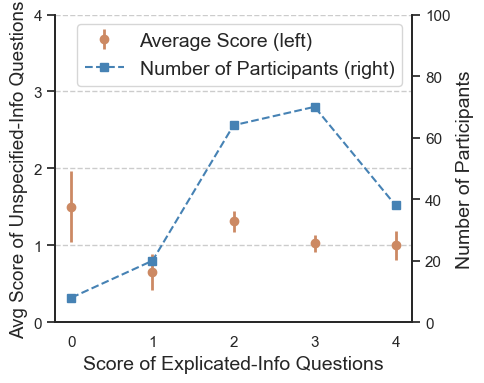

In [390]:
## Analysis on a little comprehension is dangerous
comp_score_df = pd.DataFrame()

comp_score_df["tf_correct"] = all_score_tf[["score1", "score2", "score3", "score4"]].sum(axis=1)
comp_score_df["ct_correct"] = all_score_ct[["score1", "score2", "score3", "score4"]].sum(axis=1)

grouped_score = comp_score_df.groupby("tf_correct")["ct_correct"].agg(["mean", "sem"]).reset_index()
# print(grouped_score)

fig, ax = plt.subplots(figsize=(5, 4))
ax.set_ylim(0,4)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.errorbar(grouped_score['tf_correct'], grouped_score['mean'], yerr=grouped_score['sem'], fmt='o', color="#cc8963", label="Average Score (left)", capsize=0, elinewidth=2, capthick=5)
ax.set_xlabel("Score of Explicated-Info Questions", fontsize=14)
ax.set_ylabel("Avg Score of Unspecified-Info Questions", fontsize=13.5)
ax.grid(linestyle="--", axis="y", zorder=-1)

ax2 = ax.twinx()
tf_correct_counts = comp_score_df['tf_correct'].value_counts().sort_index()
ax2.plot(tf_correct_counts.index, tf_correct_counts.values, color='steelblue', linestyle='dashed', marker='s', label="Number of Participants (right)")
ax2.set_ylabel("Number of Participants", fontsize=14)
ax2.set_ylim(0, 100)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=14)
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.savefig("../figures/tf_ct_comp.pdf", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [391]:
## one-way ANOVA
grouped = comp_score_df.groupby("tf_correct")["ct_correct"]
groups = [grouped.get_group(group) for group in grouped.groups]
f_statistic, p_value = stats.f_oneway(*groups)

print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 1.98152607511189
p-value: 0.09883606726162122


In [392]:
# print(all_score_tf[["score1"]].mean())
# print(all_score_tf[["score1"]].std())
# print(all_score_tf[["score2"]].mean())
# print(all_score_tf[["score2"]].std())
# print(all_score_tf[["score3"]].mean())
# print(all_score_tf[["score3"]].std())
# print(all_score_tf[["score4"]].mean())
# print(all_score_tf[["score4"]].std())
# print(all_score_ct[["score3"]].mean())
# print(all_score_ct[["score3"]].std())


In [393]:
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q

contingency_table = pd.crosstab(all_score_tf['score1'], all_score_tf['score2'])
print(mcnemar(contingency_table, exact=False, correction=False))

contingency_table = pd.crosstab(all_score_tf['score1'], all_score_tf['score3'])
print(mcnemar(contingency_table, exact=False, correction=False))

contingency_table = pd.crosstab(all_score_tf['score1'], all_score_tf['score4'])
print(mcnemar(contingency_table, exact=False, correction=False))

contingency_table = pd.crosstab(all_score_tf['score2'], all_score_tf['score3'])
print(mcnemar(contingency_table, exact=False, correction=False))

contingency_table = pd.crosstab(all_score_tf['score2'], all_score_tf['score4'])
print(mcnemar(contingency_table, exact=False, correction=False))

pvalue      1.9034055630689197e-05
statistic   18.28358208955224
pvalue      0.0024418344202767873
statistic   9.183673469387756
pvalue      0.00014688180920876216
statistic   14.411764705882353
pvalue      2.577992711844737e-11
statistic   44.473684210526315
pvalue      5.200718066159847e-13
statistic   52.12765957446808


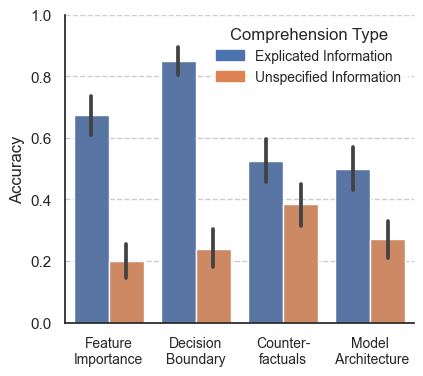

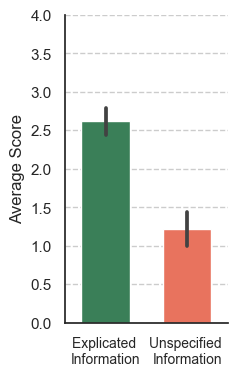

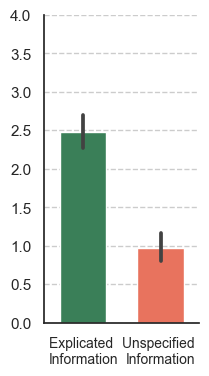

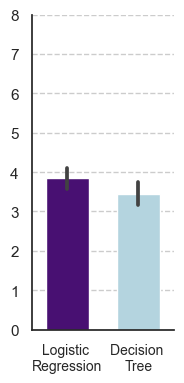

In [394]:
logreg_tf_user_score = logreg_user_score.loc[:, ["l1_tf", "l2_tf", "l3_tf", "l4_tf"]].sum(axis=1)
logreg_ct_user_score = logreg_user_score.loc[:, ["l1_ct", "l2_ct", "l3_ct", "l4_ct"]].sum(axis=1)
dect_tf_user_score = dect_user_score.loc[:, ["d1_tf", "d2_tf", "d3_tf", "d4_tf"]].sum(axis=1)
dect_ct_user_score = dect_user_score.loc[:, ["d1_ct", "d2_ct", "d3_ct", "d4_ct"]].sum(axis=1)

# st_ci = stats.t.interval(0.95, len(logreg_tf_user_score)-1, loc=np.mean(logreg_tf_user_score), scale=stats.sem(logreg_tf_user_score))
# print("95% \confidence interval:", st_ci)
# print("standard error:", stats.sem(logreg_tf_user_score))

# lr_tf_mean = np.mean(logreg_tf_user_score)
# lr_tf_ci_95 = statsmodels.stats.api.DescrStatsW(logreg_tf_user_score).tconfint_mean(alpha=0.05)
# print("lr tf mean: {}, ci: {}".format(lr_tf_mean, lr_tf_ci_95))

fig0, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4))
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(2.1, 4))
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(2, 4))
fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(2, 4))

# ax[0].yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))


sns.barplot(data=df_melted, x='score_type', y='score', hue='type', errorbar="ci", ax=ax0)

ax0.set_ylabel("Accuracy")
ax0.set_xticklabels(labels =["Feature\nImportance", "Decision\nBoundary", "Counter-\nfactuals", "Model\n Architecture"], fontsize=10)
ax0.xaxis.label.set_visible(False) 

ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.grid(linestyle="--", axis="y", zorder=-1)
ax0.set_ylim(0,1)

patches = [mpl.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(["Explicated Information","Unspecified Information"])]
ax0.legend(handles=patches, loc="upper right", title="Comprehension Type", fontsize=10, edgecolor="white") 


sns.barplot(data= [logreg_tf_user_score, logreg_ct_user_score], 
            errorbar="ci", ax=ax1, width=0.6, palette=["seagreen", "tomato"])
ax1.set_xticklabels(["Explicated \nInformation", "Unspecified \nInformation"], fontsize=10)

# ax[1].set_xlabel("Logistic Regression", fontdict=dict(weight='bold'))
ax1.set_ylabel("Average Score")
ax1.set_ylim(0, 4)

sns.barplot(data= [dect_tf_user_score, dect_ct_user_score], 
            errorbar="ci", ax=ax2, width=0.6, palette=["seagreen", "tomato"])
ax2.set_xticklabels(["Explicated \nInformation", "Unspecified \nInformation"], fontsize=10)
# ax[2].set_xlabel("Decision Tree",fontdict=dict(weight='bold'))
ax2.set_ylim(0,4)

sns.barplot(data= [logreg_user_score["avg"], dect_user_score["avg"]], 
            errorbar="ci", ax=ax3, width=0.6, palette=["indigo", "lightblue"])
ax3.set_xticklabels(["Logistic \nRegression", "Decision \nTree"], fontsize=10)
# ax[3].set_xlabel("Overall Comprehension", fontdict=dict(weight='bold'))
ax3.set_ylim(0,8)

# for i in range(1,4):
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(linestyle="--", axis="y", zorder=-1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(linestyle="--", axis="y", zorder=-1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.grid(linestyle="--", axis="y", zorder=-1)

plt.tight_layout()
# plt.savefig("../figures/overall_compare.pdf", dpi=300, transparent=True, bbox_inches="tight")

fig0.savefig("../figures/overall_compare0.pdf", dpi=300, transparent=True, bbox_inches="tight")
fig1.savefig("../figures/overall_compare1.pdf", dpi=300, transparent=True, bbox_inches="tight")
fig2.savefig("../figures/overall_compare2.pdf", dpi=300, transparent=True, bbox_inches="tight")
fig3.savefig("../figures/overall_compare3.pdf", dpi=300, transparent=True, bbox_inches="tight")

plt.show()


In [395]:
# showing accuracy trends
# how many people could get the questions correctly in LR

# fig, ax = plt.subplots(figsize=(5,4))
# # ax = sns.barplot(data = logreg_user_score.loc[:,["l1_tf","l2_tf","l3_tf", "l4_tf"]], dodge=True, width=0.4, errorbar="se")
# # ax = sns.barplot(logreg_user_score.loc[:,["l1_ct","l2_ct","l3_ct", "l4_ct"]], width=0.4, errorbar="se", dodge=True)

# melted_df = pd.melt(logreg_score_df, id_vars=["exp_id"], value_vars=["tf_answer", "ct_answer"], 
# var_name="Comprehension type", value_name="acc")
# sns.barplot(x="exp_id", y="acc", hue="Comprehension type", data=melted_df, errorbar="se")

# # ax.set_title("Accuracy in comprehension questions for logistic regression")
# ax.set(xticklabels=["ft importance", "dec boundary", "counterfactual", "transparent"], xlabel="Logistic Regression", ylabel="Accuracy")
# patches = [mpl.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(["true/false","can't tell"])]
# plt.legend(handles=patches, loc="upper right", title="Comprehension Type")    
# ax.set_ylim(0,1)
# plt.tight_layout()
# plt.show()

In [396]:
# fig, ax = plt.subplots(figsize=(5,4))

# melted_df = pd.melt(dectree_score_df, id_vars=["exp_id"], value_vars=["tf_answer", "ct_answer"], 
# var_name="Comprehension type", value_name="acc")
# sns.barplot(x="exp_id", y="acc", hue="Comprehension type", data=melted_df, errorbar="se")

# # ax.set_title("Accuracy in comprehension questions for dec tree")
# ax.set(xticklabels=["ft importance", "dec boundary", "counterfactual", "transparent"], xlabel="Decision Tree", ylabel="Accuracy")
# patches = [mpl.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(["true/false","can't tell"])]
# plt.legend(handles=patches, loc="upper right", title="Comprehension Type")    
# ax.set_ylim(0,1)
# plt.tight_layout()
# plt.show()


In [397]:
# fig, ax = plt.subplots(figsize=(6,4))
# ax = sns.barplot(dect_user_score.loc[:,["d1_tf","d2_tf","d3_tf", "d4_tf"]], width=0.4, errorbar="se")
# ax.set_title("Accuracy in T/F questions for decision tree")
# ax.set(xticklabels=["ft importance", "dec boundary", "counterfactual", "transparent"], xlabel="Decision Tree", ylabel="Accuracy")
# ax.set_ylim(0,1)

# plt.show()

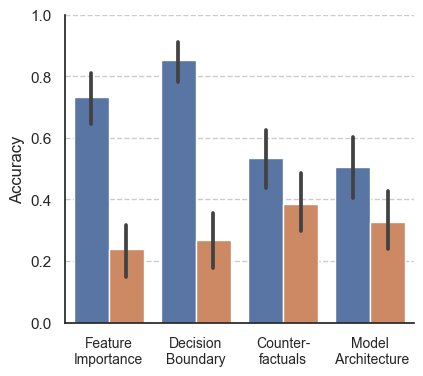

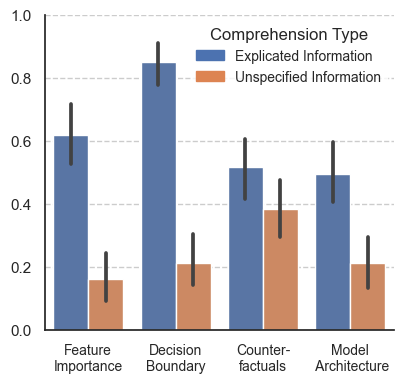

In [398]:
fig0, ax0 = plt.subplots(figsize=(4.5,4), ncols=1)
fig1, ax1 = plt.subplots(figsize=(4.2,4), ncols=1)

melted_df = pd.melt(logreg_score_df, id_vars=["exp_id"], value_vars=["tf_answer", "ct_answer"], 
var_name="Comprehension type", value_name="acc")
sns.barplot(x="exp_id", y="acc", hue="Comprehension type", data=melted_df, errorbar="ci", ax=ax0)

melted_df = pd.melt(dectree_score_df, id_vars=["exp_id"], value_vars=["tf_answer", "ct_answer"], 
var_name="Comprehension type", value_name="acc")
sns.barplot(x="exp_id", y="acc", hue="Comprehension type", data=melted_df, errorbar="ci", ax=ax1)

ax0.set_ylabel("Accuracy")
# ax[0].set_xlabel("Logistic Regression", fontdict=dict(weight='bold'))
ax0.set(xlabel="")
ax0.set_xticklabels(labels =["Feature\nImportance", "Decision\nBoundary", "Counter-\nfactuals", "Model\n Architecture"], fontsize=10)
ax0.legend().set_visible(False) 
ax0.set_ylim(0,1)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.grid(linestyle="--", axis="y", zorder=-1)


# ax[1].set_xlabel("Decision Tree", fontdict=dict(weight='bold'))
ax1.set(xlabel="")
ax1.set_xticklabels(labels =["Feature\nImportance", "Decision\nBoundary", "Counter-\nfactuals", "Model\n Architecture"], fontsize=10)
ax1.yaxis.label.set_visible(False)
patches = [mpl.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(["Explicated Information","Unspecified Information"])]
ax1.legend(handles=patches, loc="upper right", title="Comprehension Type", fontsize=10, edgecolor="white")    
ax1.set_ylim(0,1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(linestyle="--", axis="y", zorder=-1)

plt.tight_layout()
fig0.savefig("../figures/comprehension_two_models_0.pdf", dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)
fig1.savefig("../figures/comprehension_two_models_1.pdf", dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

In [399]:
# how many people could get the comprehension questions correctly 

# lr_ft_score = logreg_user_score[["l1_tf", "l1_ct"]].melt().rename({"value":"score"}, axis=1)
# dt_ft_score = dect_user_score[["d1_tf", "d1_ct"]].melt().rename({"value":"score"}, axis=1)
# ft_score = pd.concat([lr_ft_score, dt_ft_score]).drop(columns = ["variable"]).reset_index(drop=True)

# lr_db_score = logreg_user_score[["l2_tf", "l2_ct"]].melt().rename({"value":"score"}, axis=1)
# dt_db_score = dect_user_score[["d2_tf", "d2_ct"]].melt().rename({"value":"score"}, axis=1)
# db_score = pd.concat([lr_db_score, dt_db_score]).drop(columns = ["variable"]).reset_index(drop=True)

# lr_cf_score = logreg_user_score[["l3_tf", "l3_ct"]].melt().rename({"value":"score"}, axis=1)
# dt_cf_score = dect_user_score[["d3_tf", "d3_ct"]].melt().rename({"value":"score"}, axis=1)
# cf_score = pd.concat([lr_cf_score, dt_cf_score]).drop(columns = ["variable"]).reset_index(drop=True)

# lr_algo_score = logreg_user_score[["l4_tf", "l4_ct"]].melt().rename({"value":"score"}, axis=1)
# dt_algo_score = dect_user_score[["d4_tf", "d4_ct"]].melt().rename({"value":"score"}, axis=1)
# algo_score = pd.concat([lr_algo_score, dt_algo_score]).drop(columns = ["variable"]).reset_index(drop=True)


# all_score = pd.concat([ft_score, db_score, cf_score, algo_score], axis=1)

# fig, ax = plt.subplots(figsize=(6,4))
# ax = sns.barplot(data=[all_score.iloc[:,0],all_score.iloc[:,1], all_score.iloc[:,2], all_score.iloc[:,3]], width=0.4, errorbar="ci")
# ax.set_title("Accuracy in overall comprehension questions between explanations")
# ax.set(xticklabels=["ft importance", "dec boundary", "counterfactual", "transparent"], ylabel="Accuracy")
# ax.set_ylim(0,1)
# plt.show()


In [400]:
for i in range(1, 5):
    logreg_user_score["l{}tf-conf".format(i)] = pd.to_numeric(response_df["confidence-l{}tf_1".format(i)][2:].reset_index(drop=True))
    logreg_user_score["l{}ct-conf".format(i)] = pd.to_numeric(response_df["confidence-l{}ct_1".format(i)][2:].reset_index(drop=True))
    dect_user_score["d{}tf-conf".format(i)] = pd.to_numeric(response_df["confidence-d{}tf_1".format(i)][2:].reset_index(drop=True))
    dect_user_score["d{}ct-conf".format(i)] = pd.to_numeric(response_df["confidence-d{}ct_1".format(i)][2:].reset_index(drop=True))

print(dect_user_score.columns)

Index(['user_id', 'model', 'exp_id', 'type', 'd1_tf', 'd1_ct', 'd2_tf',
       'd2_ct', 'd3_tf', 'd3_ct', 'd4_tf', 'd4_ct', 'avg', 'd1tf-conf',
       'd1ct-conf', 'd2tf-conf', 'd2ct-conf', 'd3tf-conf', 'd3ct-conf',
       'd4tf-conf', 'd4ct-conf'],
      dtype='object')


In [401]:
# paired t-test to compare between tf and ct confidence within the same explanation type (combine AI model)

def ttest_tf_ct_within_diff():
    print("difference between t/f comprehension and c/t comprehension within an explanation")
    
    for i in range(1, 5):
        # combine score with confidence
        p_conf_lr_tf = np.where(logreg_user_score["l{}_tf".format(i)]==1, logreg_user_score["l{}tf-conf".format(i)], -logreg_user_score["l{}tf-conf".format(i)])
        p_conf_lr_ct = np.where(logreg_user_score["l{}_ct".format(i)]==1, logreg_user_score["l{}ct-conf".format(i)], -logreg_user_score["l{}ct-conf".format(i)])
        p_conf_dt_tf = np.where(dect_user_score["d{}_tf".format(i)]==1, dect_user_score["d{}tf-conf".format(i)], -dect_user_score["d{}tf-conf".format(i)])
        p_conf_dt_ct = np.where(dect_user_score["d{}_ct".format(i)]==1, dect_user_score["d{}ct-conf".format(i)], -dect_user_score["d{}ct-conf".format(i)])

        result = stats.ttest_rel(np.concatenate((p_conf_lr_tf, p_conf_dt_tf)), np.concatenate((p_conf_lr_ct, p_conf_dt_ct)))
        print("explanation {}: {}".format(i, result))

ttest_tf_ct_within_diff()

difference between t/f comprehension and c/t comprehension within an explanation
explanation 1: TtestResult(statistic=11.805772378331563, pvalue=1.0049237711174146e-24, df=199)
explanation 2: TtestResult(statistic=16.556080179226406, pvalue=2.7967281159608352e-39, df=199)
explanation 3: TtestResult(statistic=3.88169482258821, pvalue=0.0001410439421530324, df=199)
explanation 4: TtestResult(statistic=5.215941182387034, pvalue=4.5710447719073146e-07, df=199)


In [402]:
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q

contingency_table = pd.crosstab(logreg_user_score['l1_tf'], logreg_user_score['l1_ct'])
# print(contingency_table)
# correction is used when any of the cell counts are less than 5
print("differ in T/F and C/T for feature importance under logreg")
print(mcnemar(contingency_table, exact=False, correction=False))

contingency_table = pd.crosstab(logreg_user_score['l2_tf'], logreg_user_score['l2_ct'])
print("\ndiffer in T/F and C/T for decision boundary under logreg")
print(mcnemar(contingency_table, exact=False, correction=False))

contingency_table = pd.crosstab(logreg_user_score['l3_tf'], logreg_user_score['l3_ct'])
print("\ndiffer in T/F and C/T for counterfactuals under logreg")
print(mcnemar(contingency_table, exact=False, correction=False))

contingency_table = pd.crosstab(logreg_user_score['l4_tf'], logreg_user_score['l4_ct'])
print("\ndiffer in T/F and C/T for model explanation under logreg")
print(mcnemar(contingency_table, exact=False, correction=False))


differ in T/F and C/T for feature importance under logreg
pvalue      4.1045268504378813e-10
statistic   39.0625

differ in T/F and C/T for decision boundary under logreg
pvalue      2.5231285399102875e-12
statistic   49.028169014084504

differ in T/F and C/T for counterfactuals under logreg
pvalue      0.046944726978481816
statistic   3.9473684210526314

differ in T/F and C/T for model explanation under logreg
pvalue      0.033894853524689295
statistic   4.5


In [403]:
contingency_table = pd.crosstab(dect_user_score['d1_tf'], dect_user_score['d1_ct'])
print("differ in T/F and C/T for feature importance under dectree")
print(mcnemar(contingency_table, exact=False, correction=False))

contingency_table = pd.crosstab(dect_user_score['d2_tf'], dect_user_score['d2_ct'])
print("\ndiffer in T/F and C/T for decision boundary under dectree")
print(mcnemar(contingency_table, exact=False, correction=False))

contingency_table = pd.crosstab(dect_user_score['d3_tf'], dect_user_score['d3_ct'])
print("\ndiffer in T/F and C/T for counterfactuals under dectree")
print(mcnemar(contingency_table, exact=False, correction=False))

contingency_table = pd.crosstab(dect_user_score['d4_tf'], dect_user_score['d4_ct'])
print("\ndiffer in T/F and C/T for model explanation under dectree")
print(mcnemar(contingency_table, exact=False, correction=False))

differ in T/F and C/T for feature importance under dectree
pvalue      2.5162801118923156e-09
statistic   35.526315789473685

differ in T/F and C/T for decision boundary under dectree
pvalue      3.3426433677103985e-14
statistic   57.52173913043478

differ in T/F and C/T for counterfactuals under dectree
pvalue      0.07961580146011353
statistic   3.0727272727272728

differ in T/F and C/T for model explanation under dectree
pvalue      2.4304960694778984e-05
statistic   17.818181818181817


In [404]:
contingency_table_1 = pd.crosstab(logreg_user_score['l1_tf'], logreg_user_score['l1_ct'])
contingency_table_2 = pd.crosstab(dect_user_score['d1_tf'], dect_user_score['d1_ct'])
c_table = contingency_table_1 + contingency_table_2
# print(cont)
# correction is used when any of the cell counts are less than 5
print("differ in T/F and C/T for feature importance")
print(mcnemar(c_table, exact=False, correction=False))

contingency_table_1 = pd.crosstab(logreg_user_score['l2_tf'], logreg_user_score['l2_ct'])
contingency_table_2 = pd.crosstab(dect_user_score['d2_tf'], dect_user_score['d2_ct'])
c_table = contingency_table_1 + contingency_table_2
print("\ndiffer in T/F and C/T for decision boundary")
print(mcnemar(c_table, exact=False, correction=False))

contingency_table_1 = pd.crosstab(logreg_user_score['l3_tf'], logreg_user_score['l3_ct'])
contingency_table_2 = pd.crosstab(dect_user_score['d3_tf'], dect_user_score['d3_ct'])
c_table = contingency_table_1 + contingency_table_2
print("\ndiffer in T/F and C/T for counterfactuals")
print(mcnemar(c_table, exact=False, correction=False))

contingency_table_1 = pd.crosstab(logreg_user_score['l4_tf'], logreg_user_score['l4_ct'])
contingency_table_2 = pd.crosstab(dect_user_score['d4_tf'], dect_user_score['d4_ct'])
c_table = contingency_table_1 + contingency_table_2
print("\ndiffer in T/F and C/T for model explanation")
print(mcnemar(c_table, exact=False, correction=False))


differ in T/F and C/T for feature importance
pvalue      5.803059470553028e-18
statistic   74.58677685950413

differ in T/F and C/T for decision boundary
pvalue      6.292124463225869e-25
statistic   106.31428571428572

differ in T/F and C/T for counterfactuals
pvalue      0.008150971593502705
statistic   7.0

differ in T/F and C/T for model explanation
pvalue      1.9460471096554134e-05
statistic   18.24137931034483


In [405]:
# independent t-test to compare average diff in comprehension

print("t-test for overall comprehension between LR and DT:", stats.ttest_ind(logreg_user_score["avg"], dect_user_score["avg"]))
print("t-test for t/f comprehension between LR and DT", stats.ttest_ind(logreg_tf_user_score, dect_tf_user_score))
print("t-test for c/t comprehension between LR and DT", stats.ttest_ind(logreg_tf_user_score, dect_ct_user_score))


t-test for overall comprehension between LR and DT: Ttest_indResult(statistic=1.9374907066138125, pvalue=0.054107976721874784)
t-test for t/f comprehension between LR and DT Ttest_indResult(statistic=1.0173226495464602, pvalue=0.3102414332561484)
t-test for c/t comprehension between LR and DT Ttest_indResult(statistic=12.046994314441811, pvalue=1.978928506620457e-25)


In [406]:
logreg_user_score_temp = logreg_user_score.rename(columns = {"l1_tf": "e1_tf", "l2_tf": "e2_tf", "l3_tf": "e3_tf", "l4_tf": "e4_tf", 
                                                    "l1_ct": "e1_ct", "l2_ct": "e2_ct", "l3_ct": "e3_ct", "l4_ct": "e4_ct"})

dect_user_score_temp = dect_user_score.rename(columns = {"d1_tf": "e1_tf", "d2_tf": "e2_tf", "d3_tf": "e3_tf", "d4_tf": "e4_tf", 
                                                    "d1_ct": "e1_ct", "d2_ct": "e2_ct", "d3_ct": "e3_ct", "d4_ct": "e4_ct"})
combined_user_score = pd.concat([logreg_user_score_temp.iloc[:, :13], dect_user_score_temp.iloc[:, :13]])
print(combined_user_score)

     user_id model exp_id    type  e1_tf  e1_ct  e2_tf  e2_ct  e3_tf  e3_ct   
0          0    lr     ft  global    0.0    0.0    0.0    1.0    0.0    1.0  \
2          2    lr     ft  global    1.0    1.0    1.0    1.0    0.0    1.0   
3          3    lr     ft  global    1.0    0.0    1.0    0.0    0.0    0.0   
5          5    lr     ft  global    1.0    1.0    1.0    0.0    0.0    0.0   
9          9    lr     ft  global    0.0    0.0    1.0    0.0    0.0    0.0   
..       ...   ...    ...     ...    ...    ...    ...    ...    ...    ...   
188      188    dt     ft  global    0.0    0.0    1.0    0.0    1.0    0.0   
189      189    dt     ft  global    0.0    0.0    0.0    1.0    0.0    1.0   
192      192    dt     ft  global    1.0    0.0    1.0    0.0    1.0    0.0   
194      194    dt     ft  global    1.0    0.0    1.0    0.0    0.0    1.0   
197      197    dt     ft  global    1.0    0.0    1.0    0.0    1.0    0.0   

     e4_tf  e4_ct  avg  
0      1.0    0.0  3.0  
2

In [407]:
# Cochran's Q test
print("differ in T/F across 4 explanations")
print(cochrans_q(combined_user_score[["e1_tf", "e2_tf", "e3_tf", "e4_tf"]]))

print("\ndiffer in C/T across 4 explanations")
print(cochrans_q(combined_user_score[["e1_ct", "e2_ct", "e3_ct", "e4_ct"]]))

print("\ndiffer in T/F across 4 explanations under log reg")
print(cochrans_q(logreg_user_score[["l1_tf", "l2_tf", "l3_tf", "l4_tf"]]))

print("\ndiffer in T/F across 4 explanations under dectree")
print(cochrans_q(dect_user_score[["d1_tf", "d2_tf", "d3_tf", "d4_tf"]]))

print("\ndiffer in C/T across 4 explanations under logreg")
print(cochrans_q(logreg_user_score[["l1_ct", "l2_ct", "l3_ct", "l4_ct"]]))

print("\ndiffer in C/T across 4 explanations under dectree")
print(cochrans_q(dect_user_score[["d1_ct", "d2_ct", "d3_ct", "d4_ct"]]))


differ in T/F across 4 explanations
df          3
pvalue      2.256325288316309e-15
statistic   71.29277566539923

differ in C/T across 4 explanations
df          3
pvalue      5.460508115113921e-05
statistic   22.37100737100737

differ in T/F across 4 explanations under log reg
df          3
pvalue      4.891376605033127e-08
statistic   36.874538745387454

differ in T/F across 4 explanations under dectree
df          3
pvalue      6.270030000698319e-08
statistic   36.36470588235294

differ in C/T across 4 explanations under logreg
df          3
pvalue      0.054505002485892046
statistic   7.62200956937799

differ in C/T across 4 explanations under dectree
df          3
pvalue      0.0007593028836785007
statistic   16.848484848484848


In [408]:
# repeated ANOVA across 4 explanations with one model

p_conf_l1_tf = np.where(logreg_user_score["l1_tf"]==1, logreg_user_score["l1tf-conf"], logreg_user_score["l1tf-conf"])
p_conf_l2_tf = np.where(logreg_user_score["l2_tf"]==1, logreg_user_score["l2tf-conf"], logreg_user_score["l2tf-conf"])
p_conf_l3_tf = np.where(logreg_user_score["l3_tf"]==1, logreg_user_score["l3tf-conf"], logreg_user_score["l3tf-conf"])
p_conf_l4_tf = np.where(logreg_user_score["l4_tf"]==1, logreg_user_score["l4tf-conf"], logreg_user_score["l4tf-conf"])

logreg_score_df["tf_confidence"] = np.concatenate((p_conf_l1_tf, p_conf_l2_tf, p_conf_l3_tf, p_conf_l4_tf))
# print(logreg_score_df)

print("t/f comprehension between explanations under LR")
print(AnovaRM(data=logreg_score_df, depvar="tf_confidence", subject="user_id", within=["exp_id"]).fit())

t/f comprehension between explanations under LR
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
exp_id 17.1182 3.0000 300.0000 0.0000



In [409]:
plot_df_lr = pd.melt(logreg_user_score, id_vars=['l1_tf', 'l2_tf', 'l3_tf', 'l4_tf'], 
                   value_vars=['l1tf-conf', 'l2tf-conf', 'l3tf-conf', 'l4tf-conf'], 
                   var_name='variable', value_name='value')
plot_df_lr["Group"] = ("e1tf" + plot_df_lr["l1_tf"].astype(int).astype(str))[:101].tolist() + ("e2tf" + plot_df_lr["l2_tf"].astype(int).astype(str))[101:202].tolist() + ("e3tf" + plot_df_lr["l3_tf"].astype(int).astype(str))[202:303].tolist() + ("e4tf" + plot_df_lr["l4_tf"].astype(int).astype(str))[303:404].tolist()

plot_df_lr.rename(columns={"l1_tf": "e1_tf", "l2_tf": "e2_tf", "l3_tf": "e3_tf", "l4_tf": "e4_tf", "l1tf-conf": "e1tf-conf", "l2tf-conf": "e2tf-conf", "l3tf-conf": "e3tf-conf", "l4tf-conf": "e4tf-conf"}, inplace=True)

plot_df_dt = pd.melt(dect_user_score, id_vars=['d1_tf', 'd2_tf', 'd3_tf', 'd4_tf'], 
                   value_vars=['d1tf-conf', 'd2tf-conf', 'd3tf-conf', 'd4tf-conf'], 
                   var_name='variable', value_name='value')
plot_df_dt["Group"] = ("e1tf" + plot_df_dt["d1_tf"].astype(int).astype(str))[:101].tolist() + ("e2tf" + plot_df_dt["d2_tf"].astype(int).astype(str))[101:202].tolist() + ("e3tf" + plot_df_dt["d3_tf"].astype(int).astype(str))[202:303].tolist() + ("e4tf" + plot_df_dt["d4_tf"].astype(int).astype(str))[303:404].tolist()

plot_df_dt.rename(columns={"d1_tf": "e1_tf", "d2_tf": "e2_tf", "d3_tf": "e3_tf", "d4_tf": "e4_tf", "d1tf-conf": "e1tf-conf", "d2tf-conf": "e2tf-conf", "d3tf-conf": "e3tf-conf", "d4tf-conf": "e4tf-conf"}, inplace=True)

plot_df = pd.concat([plot_df_lr, plot_df_dt], axis=0)

In [410]:
plot_ct_lr = pd.melt(logreg_user_score, id_vars=['l1_ct', 'l2_ct', 'l3_ct', 'l4_ct'], 
                   value_vars=['l1ct-conf', 'l2ct-conf', 'l3ct-conf', 'l4ct-conf'], 
                   var_name='variable', value_name='value')
plot_ct_lr["Group"] = ("e1ct" + plot_ct_lr["l1_ct"].astype(int).astype(str))[:101].tolist() + ("e2ct" + plot_ct_lr["l2_ct"].astype(int).astype(str))[101:202].tolist() + ("e3ct" + plot_ct_lr["l3_ct"].astype(int).astype(str))[202:303].tolist() + ("e4ct" + plot_ct_lr["l4_ct"].astype(int).astype(str))[303:404].tolist()

plot_ct_lr.rename(columns={"l1_ct": "e1_ct", "l2_ct": "e2_ct", "l3_ct": "e3_ct", "l4_ct": "e4_ct", "l1ct-conf": "e1ct-conf", "l2ct-conf": "e2ct-conf", "l3ct-conf": "e3ct-conf", "l4ct-conf": "e4ct-conf"}, inplace=True)

plot_ct_dt = pd.melt(dect_user_score, id_vars=['d1_ct', 'd2_ct', 'd3_ct', 'd4_ct'], 
                   value_vars=['d1ct-conf', 'd2ct-conf', 'd3ct-conf', 'd4ct-conf'], 
                   var_name='variable', value_name='value')
plot_ct_dt["Group"] = ("e1ct" + plot_ct_dt["d1_ct"].astype(int).astype(str))[:101].tolist() + ("e2ct" + plot_ct_dt["d2_ct"].astype(int).astype(str))[101:202].tolist() + ("e3ct" + plot_ct_dt["d3_ct"].astype(int).astype(str))[202:303].tolist() + ("e4ct" + plot_ct_dt["d4_ct"].astype(int).astype(str))[303:404].tolist()

plot_ct_dt.rename(columns={"d1_ct": "e1_ct", "d2_ct": "e2_ct", "d3_ct": "e3_ct", "d4_ct": "e4_ct", "d1ct-conf": "e1ct-conf", "d2ct-conf": "e2ct-conf", "d3ct-conf": "e3ct-conf", "d4ct-conf": "e4ct-conf"}, inplace=True)

plot_ct = pd.concat([plot_ct_lr, plot_ct_dt], axis=0)

In [411]:
print(plot_ct)

     e1_ct  e2_ct  e3_ct  e4_ct   variable  value  Group
0      0.0    1.0    1.0    0.0  l1ct-conf   77.0  e1ct0
1      1.0    1.0    1.0    0.0  l1ct-conf   75.0  e1ct1
2      0.0    0.0    0.0    0.0  l1ct-conf   77.0  e1ct0
3      1.0    0.0    0.0    1.0  l1ct-conf   76.0  e1ct1
4      0.0    0.0    0.0    0.0  l1ct-conf   61.0  e1ct0
..     ...    ...    ...    ...        ...    ...    ...
391    0.0    0.0    0.0    1.0  d4ct-conf   38.0  e4ct1
392    0.0    1.0    1.0    0.0  d4ct-conf   21.0  e4ct0
393    0.0    0.0    0.0    0.0  d4ct-conf   81.0  e4ct0
394    0.0    0.0    1.0    0.0  d4ct-conf   80.0  e4ct0
395    0.0    0.0    0.0    0.0  d4ct-conf   61.0  e4ct0

[800 rows x 7 columns]


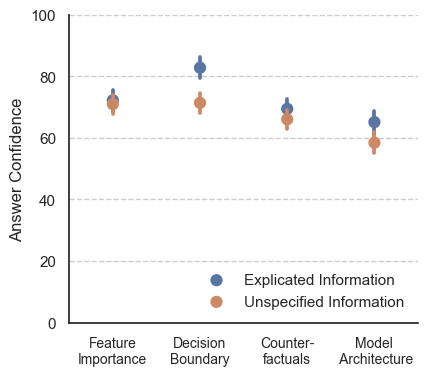

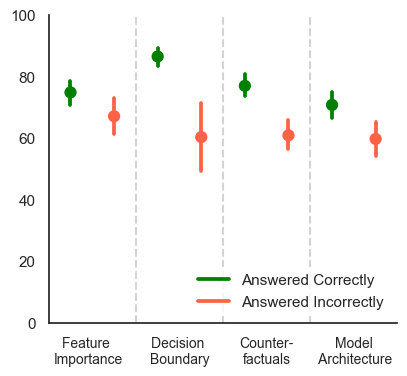

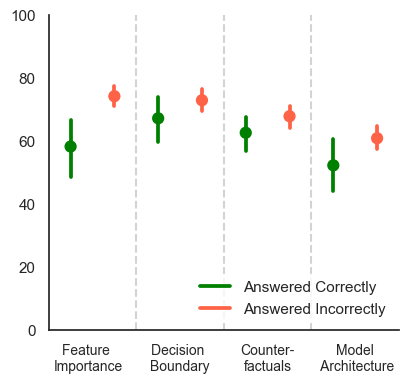

In [412]:
fig0, ax0 = plt.subplots(figsize=(4.5, 4))
fig1, ax1 = plt.subplots(figsize=(4.5, 4))
fig2, ax2 = plt.subplots(figsize=(4.25, 4))

sns.color_palette("muted")
sns.pointplot(
    data=[pd.concat([logreg_user_score["l1tf-conf"], dect_user_score["d1tf-conf"]]), 
    pd.concat([logreg_user_score["l2tf-conf"], dect_user_score["d2tf-conf"]]),
    pd.concat([logreg_user_score["l3tf-conf"], dect_user_score["d3tf-conf"]]),
    pd.concat([logreg_user_score["l4tf-conf"], dect_user_score["d4tf-conf"]])],
    errorbar=("ci", 95), capsize=0, join=False, color="#5875a4", ax=ax0, label="Explicated Information"
)

sns.pointplot(
    data=[pd.concat([logreg_user_score["l1ct-conf"], dect_user_score["d1ct-conf"]]), 
    pd.concat([logreg_user_score["l2ct-conf"], dect_user_score["d2ct-conf"]]),
    pd.concat([logreg_user_score["l3ct-conf"], dect_user_score["d3ct-conf"]]),
    pd.concat([logreg_user_score["l4ct-conf"], dect_user_score["d4ct-conf"]])],
    errorbar=("ci", 95), capsize=0, join=False, color="#cc8963", ax=ax0, label="Unspecified Information"
)

ax0.set_ylim(0,100)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.grid(linestyle="--", axis="y", zorder=-1)
ax0.set_ylabel("Answer Confidence")
ax0.set_xticklabels(labels =["Feature\nImportance", "Decision\nBoundary", "Counter-\nfactuals", "Model\n Architecture"], fontsize=10)
ax0.legend(edgecolor="white", loc="lower right")
# ax[0].legend(labels=['Known Information', 'Unknown Information'], loc='lower right', edgecolor="white", colors=["red", "blue"])


x_order = ["e1tf1","e1tf0","e2tf1","e2tf0","e3tf1","e3tf0", "e4tf1","e4tf0"]

sns.pointplot(x='Group', y='value', data=plot_df, errorbar=("ci"), join=False, dodge=True, order = x_order, palette=["green","tomato"]*4, ax=ax1)
ax1.set_xlabel([])
# ax[1].set_ylabel('Answer Confidence')
ax1.set_ylim(0,100)
ax1.axvline(x=1.5, linestyle="--", color="lightgrey")
ax1.axvline(x=3.5, linestyle="--", color="lightgrey")
ax1.axvline(x=5.5, linestyle="--", color="lightgrey")


xtick_positions = [0.4, 2.5, 4.5, 6.5]  # Adjust positions as needed
xtick_labels = ['Feature \nImportance', 'Decision \nBoundary', 'Counter-\nfactuals', "Model\n Architecture"]  
ax1.set_xticks(xtick_positions, xtick_labels, fontsize=10)
ax1.xaxis.label.set_visible(False)
ax1.yaxis.label.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(labels=['Answered Correctly', 'Answered Incorrectly'], loc='lower right', edgecolor="white")

x_order = ["e1ct1","e1ct0","e2ct1","e2ct0","e3ct1","e3ct0", "e4ct1","e4ct0"]

sns.pointplot(x='Group', y='value', data=plot_ct, errorbar=("ci"), join=False, dodge=True, order = x_order, palette=["green","tomato"]*4, ax=ax2)
ax2.set_xlabel([])
# ax.set_ylabel('Answer Confidence')
ax2.set_ylim(0,100)
ax2.axvline(x=1.5, linestyle="--", color="lightgrey")
ax2.axvline(x=3.5, linestyle="--", color="lightgrey")
ax2.axvline(x=5.5, linestyle="--", color="lightgrey")


xtick_positions = [0.4, 2.5, 4.5, 6.5]  # Adjust positions as needed
xtick_labels = ['Feature \nImportance', 'Decision \nBoundary', 'Counter-\nfactuals', "Model\n Architecture"]
ax2.set_xticks(xtick_positions, xtick_labels, fontsize=10)
ax2.yaxis.label.set_visible(False)
ax2.xaxis.label.set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(labels=['Answered Correctly', 'Answered Incorrectly'], loc='lower right', edgecolor="white")

# fig.text(0.06,1,"A. Overall Answer Confidence", fontdict=dict(weight='bold'))
# fig.text(0.36,1,"B. Answer Confidence for \n     Known-Information Questions",fontdict=dict(weight='bold'))
# fig.text(0.695,1,"C. Answer Confidence for \n     Unknown-Information Questions",fontdict=dict(weight='bold'))

plt.tight_layout()
fig0.savefig("../figures/confidence_per_exp_0.pdf", dpi=300, transparent=True, bbox_inches="tight")
fig1.savefig("../figures/confidence_per_exp_1.pdf", dpi=300, transparent=True, bbox_inches="tight")
fig2.savefig("../figures/confidence_per_exp_2.pdf", dpi=300, transparent=True, bbox_inches="tight")
plt.show()


In [413]:
print(stats.ttest_ind(plot_df.loc[plot_df['Group'] == "e1tf1"]["value"].tolist(),plot_df.loc[plot_df['Group'] == "e1tf0"]["value"].tolist()))
print(stats.ttest_ind(plot_df.loc[plot_df['Group'] == "e2tf1"]["value"].tolist(),plot_df.loc[plot_df['Group'] == "e2tf0"]["value"].tolist()))
print(stats.ttest_ind(plot_df.loc[plot_df['Group'] == "e3tf1"]["value"].tolist(),plot_df.loc[plot_df['Group'] == "e3tf0"]["value"].tolist()))
print(stats.ttest_ind(plot_df.loc[plot_df['Group'] == "e4tf1"]["value"].tolist(),plot_df.loc[plot_df['Group'] == "e4tf0"]["value"].tolist()))

Ttest_indResult(statistic=2.1738429899957454, pvalue=0.030891354982995972)
Ttest_indResult(statistic=6.118176876515995, pvalue=4.900834706203836e-09)
Ttest_indResult(statistic=5.267726076423824, pvalue=3.5565608336801313e-07)
Ttest_indResult(statistic=3.1277811885336106, pvalue=0.0020355279986619883)


In [414]:
print(stats.ttest_ind(plot_ct.loc[plot_ct['Group'] == "e1ct1"]["value"].tolist(),plot_ct.loc[plot_ct['Group'] == "e1ct0"]["value"].tolist()))
print(stats.ttest_ind(plot_ct.loc[plot_ct['Group'] == "e2ct1"]["value"].tolist(),plot_ct.loc[plot_ct['Group'] == "e2ct0"]["value"].tolist()))
print(stats.ttest_ind(plot_ct.loc[plot_ct['Group'] == "e3ct1"]["value"].tolist(),plot_ct.loc[plot_ct['Group'] == "e3ct0"]["value"].tolist()))
print(stats.ttest_ind(plot_ct.loc[plot_ct['Group'] == "e4ct1"]["value"].tolist(),plot_ct.loc[plot_ct['Group'] == "e4ct0"]["value"].tolist()))

Ttest_indResult(statistic=-4.020860881274573, pvalue=8.213469414682931e-05)
Ttest_indResult(statistic=-1.4769705779490772, pvalue=0.1412563938263181)
Ttest_indResult(statistic=-1.6401142526393626, pvalue=0.1025532562015815)
Ttest_indResult(statistic=-2.1928282783304756, pvalue=0.02952147019667806)


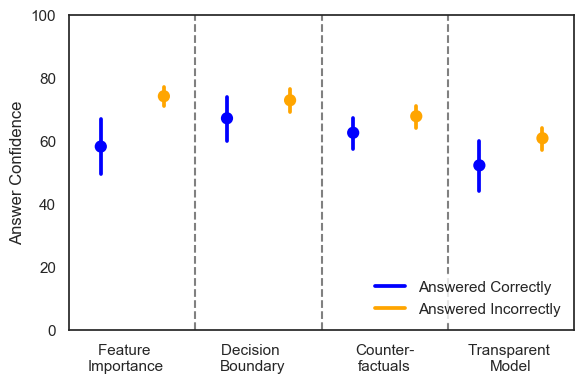

In [415]:
fig, ax= plt.subplots(figsize=(6,4))
x_order = ["e1ct1","e1ct0","e2ct1","e2ct0","e3ct1","e3ct0", "e4ct1","e4ct0"]

sns.pointplot(x='Group', y='value', data=plot_ct, errorbar=("ci"), join=False, dodge=True, order = x_order, palette=["blue","orange"]*4, ax=ax)
ax.set_xlabel([])
ax.set_ylabel('Answer Confidence')
ax.set_ylim(0,100)
ax.axvline(x=1.5, linestyle="--", color="grey")
ax.axvline(x=3.5, linestyle="--", color="grey")
ax.axvline(x=5.5, linestyle="--", color="grey")


xtick_positions = [0.4, 2.4, 4.5, 6.5]  # Adjust positions as needed
xtick_labels = ['Feature \nImportance', 'Decision \nBoundary', 'Counter-\nfactuals', "Transparent \nModel"]  # Corresponding labels
ax.set_xticks(xtick_positions, xtick_labels)
ax.xaxis.label.set_visible(False)
# ax.set_legend()
# ax.legend(edgecolor="white")
ax.legend(labels=['Answered Correctly', 'Answered Incorrectly'], loc='lower right', edgecolor="white")

plt.tight_layout()
plt.show()


In [416]:
p_conf_l1_ct = np.where(logreg_user_score["l1_ct"]==1, logreg_user_score["l1ct-conf"], logreg_user_score["l1ct-conf"])
p_conf_l2_ct = np.where(logreg_user_score["l2_ct"]==1, logreg_user_score["l2ct-conf"], logreg_user_score["l2ct-conf"])
p_conf_l3_ct = np.where(logreg_user_score["l3_ct"]==1, logreg_user_score["l3ct-conf"], logreg_user_score["l3ct-conf"])
p_conf_l4_ct = np.where(logreg_user_score["l4_ct"]==1, logreg_user_score["l4ct-conf"], logreg_user_score["l4ct-conf"])

In [417]:
# figure, ax = plt.subplots(figsize=(7, 5))

# sns.pointplot(
#     data=[p_conf_l1_tf,p_conf_l2_tf, p_conf_l3_tf, p_conf_l4_tf], #orient="h",
#     errorbar=("se"), capsize=.2, join=False, color="green", errwidth=1
# )

# sns.pointplot(
#     data=[p_conf_l1_ct,p_conf_l2_ct, p_conf_l3_ct, p_conf_l4_ct], #orient="h",
#     errorbar=("se"), capsize=.2, join=False, color="red", errwidth=1
# )
# ax.set(xticklabels=["ft importance", "dec boundary", "counterfactual", "transparent"], ylabel="Answer Confidence")
# ax.set_ylim(0,100)
# ax.set_title("confidence of true/false comprehension")

# plt.tight_layout()
# plt.show()


In [418]:
# figure, ax = plt.subplots(figsize=(7, 5))

# sns.pointplot(
#     data=[p_conf_l1_ct,p_conf_l2_ct, p_conf_l3_ct, p_conf_l4_ct],
#     errorbar=("se"), capsize=.4, join=False, color=".5",
# )
# ax.set(xticklabels=["ft importance", "dec boundary", "counterfactual", "transparent"], ylabel="Accuracy")
# ax.set_ylim(-100,100)
# ax.set_title("confidence of cant tell comprehension")

# plt.tight_layout()
# plt.show()

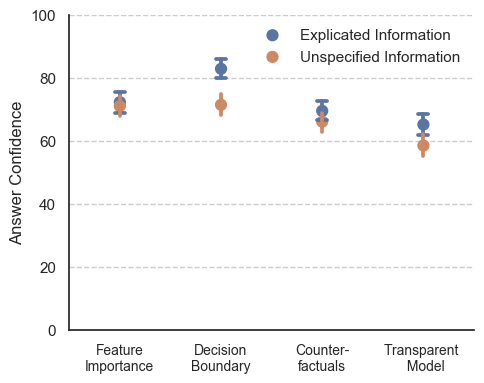

In [419]:
figure, ax = plt.subplots(figsize=(5, 4))
sns.color_palette("muted")
sns.pointplot(
    data=[pd.concat([logreg_user_score["l1tf-conf"], dect_user_score["d1tf-conf"]]), 
    pd.concat([logreg_user_score["l2tf-conf"], dect_user_score["d2tf-conf"]]),
    pd.concat([logreg_user_score["l3tf-conf"], dect_user_score["d3tf-conf"]]),
    pd.concat([logreg_user_score["l4tf-conf"], dect_user_score["d4tf-conf"]])],
    errorbar=("ci", 95), capsize=.1, join=False, color="#5875a4", ax=ax, label="Explicated Information"
)

sns.pointplot(
    data=[pd.concat([logreg_user_score["l1ct-conf"], dect_user_score["d1ct-conf"]]), 
    pd.concat([logreg_user_score["l2ct-conf"], dect_user_score["d2ct-conf"]]),
    pd.concat([logreg_user_score["l3ct-conf"], dect_user_score["d3ct-conf"]]),
    pd.concat([logreg_user_score["l4ct-conf"], dect_user_score["d4ct-conf"]])],
    errorbar=("ci", 95), capsize=0, join=False, color="#cc8963", ax=ax, label="Unspecified Information"
)

ax.set_ylim(0,100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linestyle="--", axis="y", zorder=-1)
ax.set_ylabel("Answer Confidence")
ax.set_xticklabels(labels =["Feature\nImportance", "Decision\nBoundary", "Counter-\nfactuals", "Transparent \n Model"], fontsize=10)
ax.legend(edgecolor="white")
plt.savefig("../figures/confidence_per_exp.pdf", dpi=300, transparent=True)
plt.tight_layout()
plt.show()

In [420]:
tf_avg_conf = logreg_user_score[["l1tf-conf", "l2tf-conf", "l3tf-conf", "l4tf-conf"]].mean(axis=1).tolist() + dect_user_score[["d1tf-conf", "d2tf-conf", "d3tf-conf", "d4tf-conf"]].mean(axis=1).tolist()

ct_avg_conf = logreg_user_score[["l1ct-conf", "l2ct-conf", "l3ct-conf", "l4ct-conf"]].mean(axis=1).tolist() + dect_user_score[["d1ct-conf", "d2ct-conf", "d3ct-conf", "d4ct-conf"]].mean(axis=1).tolist()

print(stats.ttest_rel(tf_avg_conf, ct_avg_conf))
print(np.mean(tf_avg_conf))
print(np.std(tf_avg_conf))

print(np.mean(ct_avg_conf))
print(np.std(ct_avg_conf))

TtestResult(statistic=6.903462954542859, pvalue=6.649539484892123e-11, df=199)
72.3625
17.238361109745902
66.67375
17.042175578179567


In [421]:
e1_tf_conf = logreg_user_score["l1tf-conf"].tolist() + dect_user_score["d1tf-conf"].tolist()
e1_ct_conf = logreg_user_score["l1ct-conf"].tolist() + dect_user_score["d1ct-conf"].tolist()
print("diff in confidence between tf and ct in feature importance")
print(stats.ttest_rel(e1_tf_conf, e1_ct_conf))

e2_tf_conf = logreg_user_score["l2tf-conf"].tolist() + dect_user_score["d2tf-conf"].tolist()
e2_ct_conf = logreg_user_score["l2ct-conf"].tolist() + dect_user_score["d2ct-conf"].tolist()
print("\ndiff in confidence between tf and ct in decision boundary")
print(stats.ttest_rel(e2_tf_conf, e2_ct_conf))

e3_tf_conf = logreg_user_score["l3tf-conf"].tolist() + dect_user_score["d3tf-conf"].tolist()
e3_ct_conf = logreg_user_score["l3ct-conf"].tolist() + dect_user_score["d3ct-conf"].tolist()
print("\ndiff in confidence between tf and ct in counterfactual")
print(stats.ttest_rel(e3_tf_conf, e3_ct_conf))

e4_tf_conf = logreg_user_score["l4tf-conf"].tolist() + dect_user_score["d4tf-conf"].tolist()
e4_ct_conf = logreg_user_score["l4ct-conf"].tolist() + dect_user_score["d4ct-conf"].tolist()
print("\ndiff in confidence between tf and ct in model exp")
print(stats.ttest_rel(e4_tf_conf, e4_ct_conf))

diff in confidence between tf and ct in feature importance
TtestResult(statistic=0.7418255008065292, pvalue=0.4590676793726409, df=199)

diff in confidence between tf and ct in decision boundary
TtestResult(statistic=6.947449320353109, pvalue=5.176887009695191e-11, df=199)

diff in confidence between tf and ct in counterfactual
TtestResult(statistic=2.073520359106008, pvalue=0.03941145276227938, df=199)

diff in confidence between tf and ct in model exp
TtestResult(statistic=4.412560575734215, pvalue=1.672676503715646e-05, df=199)


In [422]:
df1 = logreg_user_score.transpose().reset_index(drop=True).transpose()
df2 = dect_user_score.transpose().reset_index(drop=True).transpose()

user_score = pd.concat([df1, df2], ignore_index=True)

user_score.columns = logreg_user_score.columns
# user_score

   correct_tf_count       mean       sem
0               0.0        NaN       NaN
1               1.0  76.200000  5.770433
2               2.0  78.429688  2.383258
3               3.0  76.757143  1.831666
4               4.0  80.605263  2.036531


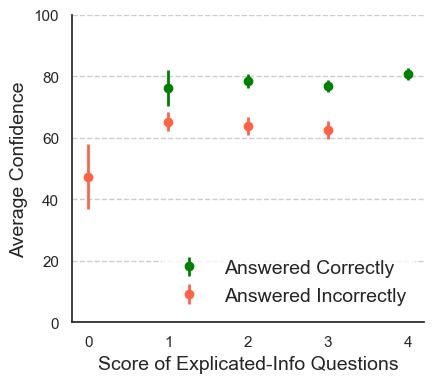

In [423]:
for i in range(1, 5):
    user_score[f'l{i}_product'] = user_score[f'l{i}_tf'] * user_score[f'l{i}tf-conf']

user_score["correct_tf_count"] = user_score[['l1_tf', 'l2_tf', 'l3_tf', 'l4_tf']].sum(axis=1)

# user_score['avg_correct_conf'] = user_score[['l1_product', 'l2_product', 'l3_product', 'l4_product']].sum(axis=1)/user_score["correct_tf_count"]

user_score['avg_correct_conf'] = user_score.apply(lambda row: np.nan if row["correct_tf_count"] == 0 else (row[['l1_product', 'l2_product', 'l3_product', 'l4_product']].sum() / row["correct_tf_count"]), axis=1)


for i in range(1, 5):
    user_score[f'l{i}_product'] = abs((user_score[f'l{i}_tf'] -1) * user_score[f'l{i}tf-conf'])
user_score['avg_incorrect_conf'] = user_score.apply(lambda row: np.nan if row["correct_tf_count"] == 4 else (row[['l1_product', 'l2_product', 'l3_product', 'l4_product']].sum() / (4-row["correct_tf_count"])), axis=1)
# user_score[['l1_product', 'l2_product', 'l3_product', 'l4_product']].sum(axis=1)/(4-user_score["correct_tf_count"])

grouped_score = user_score.groupby("correct_tf_count")["avg_correct_conf"].agg(["mean", "sem"]).reset_index()
# grouped_score = grouped_score.iloc[1:5,]
print(grouped_score)

fig, ax = plt.subplots(figsize=(4.5, 4))
ax.set_ylim(0,100)
ax.errorbar(grouped_score['correct_tf_count'], grouped_score['mean'], yerr=grouped_score['sem'], fmt='o', capsize=0, elinewidth=2, capthick=5, color="green", label="Answered Correctly")
ax.set_xlabel("Score of Explicated-Info Questions", fontsize=14)
ax.set_ylabel("Average Confidence", fontsize=14)
ax.grid(linestyle="--", axis="y", zorder=-1)

grouped_score = user_score.groupby("correct_tf_count")["avg_incorrect_conf"].agg(["mean", "sem"]).reset_index()
# print(grouped_score)

ax.errorbar(grouped_score['correct_tf_count'], grouped_score['mean'], yerr=grouped_score['sem'], fmt='o', capsize=0, elinewidth=2, capthick=5, color="tomato", label="Answered Incorrectly")
ax.legend(edgecolor="white", loc="lower right", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("../figures/tf_calibrated_conf.pdf", dpi=300, transparent=True, bbox_inches="tight")
plt.show()


   correct_ct_count       mean        sem
0               0.0        NaN        NaN
1               1.0  55.440678   3.617064
2               2.0  59.617021   3.775904
3               3.0  70.261905   3.500772
4               4.0  58.000000  13.142964


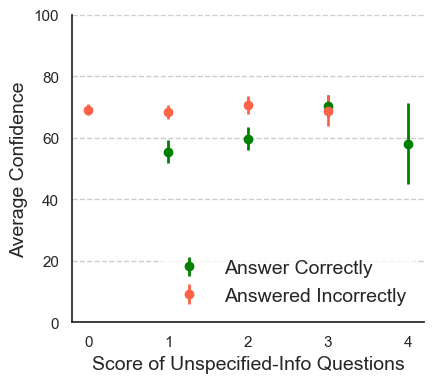

In [424]:
# user_score = logreg_user_score
for i in range(1, 5):
    user_score[f'l{i}_product'] = user_score[f'l{i}_ct'] * user_score[f'l{i}ct-conf']

user_score["correct_ct_count"] = user_score[['l1_ct', 'l2_ct', 'l3_ct', 'l4_ct']].sum(axis=1)

user_score['avg_correct_conf'] = user_score.apply(lambda row: np.nan if row["correct_ct_count"] == 0 else (row[['l1_product', 'l2_product', 'l3_product', 'l4_product']].sum() / row["correct_ct_count"]), axis=1)
# user_score[['l1_product', 'l2_product', 'l3_product', 'l4_product']].sum(axis=1)/user_score["correct_ct_count"]

for i in range(1, 5):
    user_score[f'l{i}_product'] = abs((user_score[f'l{i}_ct'] -1) * user_score[f'l{i}ct-conf'])
user_score['avg_incorrect_conf'] = user_score.apply(lambda row: np.nan if row["correct_ct_count"] == 4 else (row[['l1_product', 'l2_product', 'l3_product', 'l4_product']].sum() / (4-row["correct_ct_count"])), axis=1)
# user_score[['l1_product', 'l2_product', 'l3_product', 'l4_product']].sum(axis=1)/(4-user_score["correct_ct_count"])

grouped_score = user_score.groupby("correct_ct_count")["avg_correct_conf"].agg(["mean", "sem"]).reset_index()
# grouped_score = grouped_score.iloc[1:5,]
print(grouped_score)

fig, ax = plt.subplots(figsize=(4.5, 4))
ax.set_ylim(0,100)
# ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.errorbar(grouped_score['correct_ct_count'], grouped_score['mean'], yerr=grouped_score['sem'], fmt='o', capsize=0, elinewidth=2, capthick=5, color="green", label="Answer Correctly")
ax.set_xlabel("Score of Unspecified-Info Questions", fontsize=14)
ax.set_ylabel("Average Confidence", fontsize=14)
ax.grid(linestyle="--", axis="y", zorder=-1)


grouped_score = user_score.groupby("correct_ct_count")["avg_incorrect_conf"].agg(["mean", "sem"]).reset_index()
# grouped_score = grouped_score.iloc[1:5,]

ax.errorbar(grouped_score['correct_ct_count'], grouped_score['mean'], yerr=grouped_score['sem'], fmt='o', capsize=0, elinewidth=2, capthick=5, color="tomato", label="Answered Incorrectly")
ax.legend(loc="lower right", edgecolor="white", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("../figures/ct_calibrated_conf.pdf", dpi=300, transparent=True, bbox_inches="tight")
plt.show()


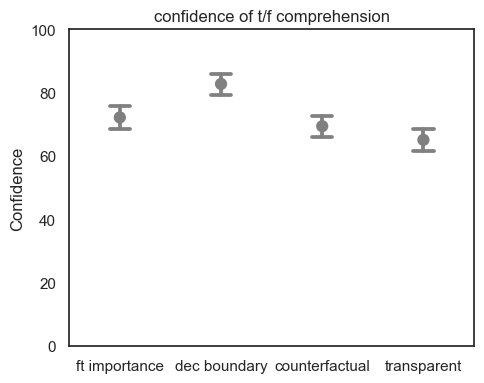

In [425]:
figure, ax = plt.subplots(figsize=(5, 4))

sns.pointplot(
    data=[pd.concat([logreg_user_score["l1tf-conf"], dect_user_score["d1tf-conf"]]), 
    pd.concat([logreg_user_score["l2tf-conf"], dect_user_score["d2tf-conf"]]),
    pd.concat([logreg_user_score["l3tf-conf"], dect_user_score["d3tf-conf"]]),
    pd.concat([logreg_user_score["l4tf-conf"], dect_user_score["d4tf-conf"]])],
    errorbar=("ci", 95), capsize=.2, join=False, color=".5",
)
ax.set(xticklabels=["ft importance", "dec boundary", "counterfactual", "transparent"], ylabel="Confidence")
ax.set_ylim(0,100)
ax.set_title("confidence of t/f comprehension")

plt.tight_layout()
plt.show()

In [426]:
# i1
age = {
    "18-24 years old": 1,
    "25-34 years old": 2,
    "35-44 years old": 3,
    "45-54 years old": 4,
    "55-64 years old": 5,
    "65+ years old": 6
}

#i2
gender = {
    "Male": 1,
    "Female": 2,
    "Prefer to self-describe": 3,
    "Prefer not to say": 3,
    "Non-binary / third gender": 3
}

#i4
education = {
    "Less than high school degree": 1,
    "High school graduate (high school diploma or equivalent including GED)": 2,
    "College degree": 3,
    "Bachelor's degree": 4,
    "Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS etc.)": 5,
    "Prefer not to say": 0 
}

#i5
stem = {
    "Yes, my education and/or employment is related to STEM field": 1,
    "No": 0,
}

#i6
ml_literacy = {
    "No knowledge": 0, 
    "Negligible knowledge: I know basic concepts in ML, but have never applied them": 1,
    "Some knowledge: I have used ML algorithms before": 2,
    "Moderate knowledge: I apply ML algorithms somewhat frequently in my work or leisure": 3
}

#i7
hcxai_ordinal = {
    "None (0)": 0,
    "A few (roughly 1-5)": 1,
    "A lot (probably more than 15)": 1,
    "A fair amount (around 6-15)": 1
}

hcxai = {
    "None (0)": "No",
    "A few (roughly 1-5)": "Yes",
    "A lot (probably more than 15)": "Yes",
    "A fair amount (around 6-15)": "Yes"
}

i2_lr_response = response_df.iloc[np.where(response_df["Model"]=="LR")]["i2"].map(gender).reset_index(drop=True).tolist()
i2_dt_response = response_df.iloc[np.where(response_df["Model"]=="DT")]["i2"].map(gender).reset_index(drop=True).tolist()

i4_lr_response = response_df.iloc[np.where(response_df["Model"]=="LR")]["i4"].map(education).reset_index(drop=True).tolist()
i4_dt_response = response_df.iloc[np.where(response_df["Model"]=="DT")]["i4"].map(education).reset_index(drop=True).tolist()


In [427]:
# regression model to test demographic variables and comprehension

i1_lr_response = response_df.iloc[np.where(response_df["Model"]=="LR")]["i1"].map(age).reset_index(drop=True).tolist()
i1_dt_response = response_df.iloc[np.where(response_df["Model"]=="DT")]["i1"].map(age).reset_index(drop=True).tolist()

i4_lr_response = response_df.iloc[np.where(response_df["Model"]=="LR")]["i4"].map(education).reset_index(drop=True).tolist()
i4_dt_response = response_df.iloc[np.where(response_df["Model"]=="DT")]["i4"].map(education).reset_index(drop=True).tolist()

i5_lr_response = response_df.iloc[np.where(response_df["Model"]=="LR")]["i5"].map(stem).reset_index(drop=True).tolist()
i5_dt_response = response_df.iloc[np.where(response_df["Model"]=="DT")]["i5"].map(stem).reset_index(drop=True).tolist()

i6_lr_response = response_df.iloc[np.where(response_df["Model"]=="LR")]["i6"].map(ml_literacy).reset_index(drop=True).tolist()
i6_dt_response = response_df.iloc[np.where(response_df["Model"]=="DT")]["i6"].map(ml_literacy).reset_index(drop=True).tolist()

i7_lr_response = response_df.iloc[np.where(response_df["Model"]=="LR")]["i7"].map(hcxai).reset_index(drop=True).tolist()
i7_dt_response = response_df.iloc[np.where(response_df["Model"]=="DT")]["i7"].map(hcxai).reset_index(drop=True).tolist()

# linear regression
## Outcome: number of questions correctly
## Predictors: age, gender, education, stem background, english, familiarity with ML

age_list = np.concatenate((i1_lr_response, i1_dt_response))
# gender_list = np.concatenate((i2_lr_response, i2_dt_response))
gender_list = pd.concat([response_df.iloc[np.where(response_df["Model"]=="LR")]["i2"], response_df.iloc[np.where(response_df["Model"]=="DT")]["i2"]]).tolist()

education_list = np.concatenate((i4_lr_response, i4_dt_response))

stem_list = pd.concat([response_df.iloc[np.where(response_df["Model"]=="LR")]["i5"], response_df.iloc[np.where(response_df["Model"]=="DT")]["i5"]]).tolist()
# stem_list = np.concatenate((i5_lr_response, i5_dt_response))

ml_literacy_list = np.concatenate((i6_lr_response, i6_dt_response))

hcxai_list = pd.concat([response_df.iloc[np.where(response_df["Model"]=="LR")]["i7"], response_df.iloc[np.where(response_df["Model"]=="DT")]["i7"]]).tolist()
hcxai_list = np.concatenate((i7_lr_response, i7_dt_response))

overall_score_list = np.concatenate((logreg_user_score["avg"], dect_user_score["avg"]), axis=0)
tf_score_list = logreg_user_score[["l1_tf", "l2_tf", "l3_tf", "l4_tf"]].sum(axis=1).tolist() + dect_user_score[["d1_tf", "d2_tf", "d3_tf", "d4_tf"]].sum(axis=1).tolist()
ct_score_list = logreg_user_score[["l1_ct", "l2_ct", "l3_ct", "l4_ct"]].sum(axis=1).tolist() + dect_user_score[["d1_ct", "d2_ct", "d3_ct", "d4_ct"]].sum(axis=1).tolist()

linear_model_df = pd.DataFrame({"tf_score": tf_score_list,
                                "ct_score": ct_score_list,
                                "score": overall_score_list, 
                                "age": age_list,
                                "gender": gender_list, 
                                "education": education_list,
                                "stem": stem_list,
                                "ml_literacy": ml_literacy_list,
                                "hcxai": hcxai_list,
                                "sgl_response": sgl_response["avg_score"].tolist()})

linear_model_df = linear_model_df[linear_model_df.gender != "Non-binary / third gender"].reset_index(drop=True)

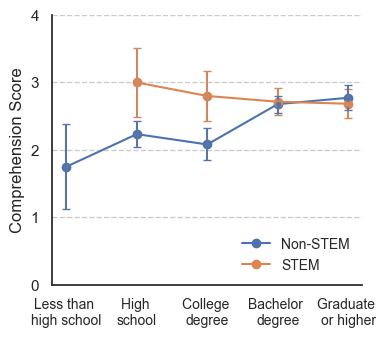

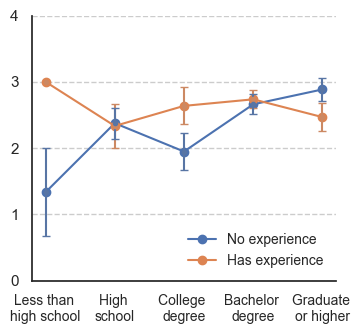

In [428]:
fig0, ax0= plt.subplots(figsize=(4, 3.5))
fig1, ax1= plt.subplots(figsize=(3.8, 3.5))

grouped = linear_model_df.groupby(['stem', 'education'])['tf_score'].agg(['mean', 'sem']).reset_index()
pivot_table = grouped.pivot(index='education', columns='stem', values='mean')

# Calculate confidence intervals (mean ± sem) * 1.96
confidence_intervals = grouped.pivot(index='education', columns='stem', values='sem')

pivot_table.plot(kind='line', marker='o', ax=ax0)
x = pivot_table.index
y_yes = pivot_table['Yes, my education and/or employment is related to STEM field']
y_no = pivot_table['No']

ax0.errorbar(x, y_yes, yerr=confidence_intervals['Yes, my education and/or employment is related to STEM field'], fmt='.', label='Yes', capsize=3, color="#cc8963")
ax0.errorbar(x, y_no, yerr=confidence_intervals['No'], fmt='.', label='No', capsize=3, color="#5875a4")

education_labels = ["Less than \nhigh school", "High \nschool", "College \ndegree", "Bachelor \ndegree", "Graduate \nor higher"]  
ax0.set_xticks(x)
ax0.set_xticklabels(education_labels, rotation=0, fontsize=10)
ax0.set_xlabel(None)
ax0.set_ylabel("Comprehension Score")
ax0.set_ylim(0,4)
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.grid(linestyle="--", axis="y", zorder=-1)
ax0.legend(labels=["Non-STEM", "STEM"], loc="lower right",edgecolor="white", fontsize=10)


grouped = linear_model_df.groupby(['hcxai', 'education'])['tf_score'].agg(['mean', 'sem']).reset_index()
pivot_table = grouped.pivot(index='education', columns='hcxai', values='mean')

# Calculate confidence intervals (mean ± sem) * 1.96
confidence_intervals = grouped.pivot(index='education', columns='hcxai', values='sem')

pivot_table.plot(kind='line', marker='o', ax=ax1)
x = pivot_table.index
y_yes = pivot_table['Yes']
y_no = pivot_table['No']

ax1.errorbar(x, y_yes, yerr=confidence_intervals['Yes'], fmt='.', label='Yes', capsize=3, color="#cc8963")
ax1.errorbar(x, y_no, yerr=confidence_intervals['No'], fmt='.', label='No', capsize=3, color="#5875a4")

ax1.set_xticks(x)
ax1.set_xticklabels(education_labels, rotation=0, fontsize=10)
ax1.set_xlabel(None)
# ax[1].set_ylabel("Comprehension Score")
ax1.set_ylim(0,4)
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(linestyle="--", axis="y", zorder=-1)
ax1.legend(labels=["No experience", "Has experience"], loc="lower right", edgecolor="white", facecolor="white", fontsize=10)

# fig.text(0.07,1,"A. Education vs. Background in STEM", fontdict=dict(weight='bold'))
# fig.text(0.54,1,"B. Education vs. Experience in XAI user studies",fontdict=dict(weight='bold'))

plt.tight_layout()
fig0.savefig("../figures/education_interaction_0.pdf", dpi=300, transparent=True, bbox_inches="tight")
fig1.savefig("../figures/education_interaction_1.pdf", dpi=300, transparent=True, bbox_inches="tight")
plt.show()


In [429]:
logreg_user_score["hcxai"] = response_df.iloc[np.where(response_df["Model"]=="LR")]["i7"].map(hcxai).reset_index(drop=True).tolist()

print(logreg_user_score.groupby("hcxai")[["l1_tf", "l2_tf", "l3_tf", "l4_tf"]].mean())
print(logreg_user_score.groupby("hcxai")[["l1_ct", "l2_ct", "l3_ct", "l4_ct"]].mean())

          l1_tf     l2_tf     l3_tf     l4_tf
hcxai                                        
No     0.660714  0.857143  0.571429  0.500000
Yes    0.822222  0.844444  0.488889  0.511111
          l1_ct     l2_ct     l3_ct     l4_ct
hcxai                                        
No     0.250000  0.267857  0.392857  0.250000
Yes    0.222222  0.266667  0.377778  0.422222


In [430]:
dect_user_score["hcxai"] = response_df.iloc[np.where(response_df["Model"]=="DT")]["i7"].map(hcxai).reset_index(drop=True).tolist()

print(dect_user_score.groupby("hcxai")[["d1_tf", "d2_tf", "d3_tf", "d4_tf"]].mean())
print(dect_user_score.groupby("hcxai")[["d1_ct", "d2_ct", "d3_ct", "d4_ct"]].mean())

          d1_tf     d2_tf     d3_tf     d4_tf
hcxai                                        
No     0.608696  0.797101  0.521739  0.507246
Yes    0.633333  0.966667  0.500000  0.466667
          d1_ct     d2_ct    d3_ct     d4_ct
hcxai                                       
No     0.202899  0.231884  0.42029  0.246377
Yes    0.066667  0.166667  0.30000  0.133333


In [431]:
print(linear_model_df.groupby("hcxai")["tf_score"].mean())
print(linear_model_df.groupby("hcxai")["tf_score"].std())


hcxai
No     2.508197
Yes    2.602740
Name: tf_score, dtype: float64
hcxai
No     1.122614
Yes    0.877809
Name: tf_score, dtype: float64


In [432]:
print(linear_model_df.groupby("stem")["tf_score"].mean())

print(linear_model_df.groupby("stem")["tf_score"].std())

stem
No                                                              2.459854
Yes, my education and/or employment is related to STEM field    2.741379
Name: tf_score, dtype: float64
stem
No                                                              1.043288
Yes, my education and/or employment is related to STEM field    1.001058
Name: tf_score, dtype: float64


In [433]:
linear_model = smf.gls(formula="tf_score ~ age + education + stem + hcxai + ml_literacy + gender", data = linear_model_df)
# + education:stem + education: hcxai + education:ml_literacy + education:hcxai + stem:hcxai + stem:ml_literacy + hcxai:ml_literacy
# + education: ml_literacy + education:gender + education:hcxai + education:stem + education:age

result = linear_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:               tf_score   R-squared:                       0.047
Model:                            GLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.549
Date:                Fri, 05 Apr 2024   Prob (F-statistic):              0.164
Time:                        16:16:50   Log-Likelihood:                -278.46
No. Observations:                 195   AIC:                             570.9
Df Residuals:                     188   BIC:                             593.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                1.8550      0.335      5.540      0.000       1.195       2.516
stem[T.Yes, my education and/or employment is related to STEM field]     0.1377      0.180      0.766      0.445      -0.217       0.492
hcxai[T.Yes]                                                             0.0563      0.157      0.358      0.721      -0.254       0.367
gender[T.Male]                                                           0.1075      0.158      0.679      0.498      -0.205       0.420
age                                                                     -0.0097      0.053     -0.183      0.855      -0.114       0.095
education                                                                0.1601      0.072      2.211      0.028       0.017       0.303
ml_literacy                                                              0.0303      0.103      0.295      0.768      -0.172       0.233
==============================================================================
Omnibus:                        5.005   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                4.924
Skew:                          -0.348   Prob(JB):                       0.0853
Kurtosis:                       2.650   Cond. No.                         23.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [434]:
## pearson correlation test
print(stats.pearsonr(tf_score_list, sgl_response["avg_score"].tolist()))
print(stats.pearsonr(ct_score_list, sgl_response["avg_score"].tolist()))
print(stats.pearsonr(overall_score_list, sgl_response["avg_score"].tolist()))


PearsonRResult(statistic=-0.19703490655692307, pvalue=0.0051660077597281895)
PearsonRResult(statistic=0.05015953770662164, pvalue=0.48058571025277047)
PearsonRResult(statistic=-0.10296314462365454, pvalue=0.14682147661831751)


In [435]:
linear_oh_df = pd.concat([linear_model_df, 
            pd.get_dummies(linear_model_df.gender, dtype=int, prefix="gender", prefix_sep="_", drop_first=True), 
            pd.get_dummies(linear_model_df.education, dtype=int, prefix="education", prefix_sep="_", drop_first=True)], axis="columns")
# dropping the original column which was not encoded
linear_oh_df.drop(["gender", "education"], axis="columns", inplace=True)
linear_oh_df = sm.add_constant(linear_oh_df, prepend=False)
X_glm = linear_oh_df.iloc[:1:]
y_glm = linear_oh_df.score
# print(linear_oh_df)

# linear_model = sm.GLS(endog=linear_oh_df.score, exog=linear_oh_df.iloc[:,1:])
# result = linear_model.fit()
# result.summary()


## subjective

In [436]:
from scipy.stats import tukey_hsd

result = tukey_hsd(l1_c_response.fillna(d1_c_response).tolist(), l2_c_response.fillna(d2_c_response).tolist(), l3_c_response.fillna(d3_c_response).tolist(), l4_c_response.fillna(d4_c_response).tolist())

print(result)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.475     0.005    -0.843    -0.107
 (0 - 2)      0.400     0.027     0.032     0.768
 (0 - 3)      1.785     0.000     1.417     2.153
 (1 - 0)      0.475     0.005     0.107     0.843
 (1 - 2)      0.875     0.000     0.507     1.243
 (1 - 3)      2.260     0.000     1.892     2.628
 (2 - 0)     -0.400     0.027    -0.768    -0.032
 (2 - 1)     -0.875     0.000    -1.243    -0.507
 (2 - 3)      1.385     0.000     1.017     1.753
 (3 - 0)     -1.785     0.000    -2.153    -1.417
 (3 - 1)     -2.260     0.000    -2.628    -1.892
 (3 - 2)     -1.385     0.000    -1.753    -1.017



In [437]:
result = tukey_hsd(l1_s_response.fillna(d1_s_response).tolist(), l2_s_response.fillna(d2_s_response).tolist(), l3_s_response.fillna(d3_s_response).tolist(), l4_s_response.fillna(d4_s_response).tolist())
print(result)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.235     0.416    -0.629     0.159
 (0 - 2)      0.830     0.000     0.436     1.224
 (0 - 3)      0.395     0.049     0.001     0.789
 (1 - 0)      0.235     0.416    -0.159     0.629
 (1 - 2)      1.065     0.000     0.671     1.459
 (1 - 3)      0.630     0.000     0.236     1.024
 (2 - 0)     -0.830     0.000    -1.224    -0.436
 (2 - 1)     -1.065     0.000    -1.459    -0.671
 (2 - 3)     -0.435     0.024    -0.829    -0.041
 (3 - 0)     -0.395     0.049    -0.789    -0.001
 (3 - 1)     -0.630     0.000    -1.024    -0.236
 (3 - 2)      0.435     0.024     0.041     0.829



In [438]:
print(stats.ttest_rel(l4_c_response.fillna(d4_c_response).tolist(), l1_c_response.fillna(d1_c_response).tolist()))
print(stats.ttest_rel(l4_c_response.fillna(d4_c_response).tolist(), l2_c_response.fillna(d2_c_response).tolist()))
print(stats.ttest_rel(l4_c_response.fillna(d4_c_response).tolist(), l3_c_response.fillna(d3_c_response).tolist()))
print(stats.ttest_rel(l3_c_response.fillna(d3_c_response).tolist(), l1_c_response.fillna(d1_c_response).tolist()))
print(stats.ttest_rel(l3_c_response.fillna(d3_c_response).tolist(), l2_c_response.fillna(d2_c_response).tolist()))
print(stats.ttest_rel(l2_c_response.fillna(d2_c_response).tolist(), l1_c_response.fillna(d1_c_response).tolist()))

TtestResult(statistic=-13.822158020316106, pvalue=6.666786841241483e-31, df=199)
TtestResult(statistic=-17.108821828420595, pvalue=5.940472950963536e-41, df=199)
TtestResult(statistic=-9.77285514256045, pvalue=1.1290707316130762e-18, df=199)
TtestResult(statistic=-3.434034448370108, pvalue=0.0007235369825627401, df=199)
TtestResult(statistic=-7.6121673335616515, pvalue=1.059298013095155e-12, df=199)
TtestResult(statistic=4.172178730280196, pvalue=4.5048888521836604e-05, df=199)


In [439]:
print(stats.ttest_rel(l4_s_response.fillna(d4_s_response).tolist(), l1_s_response.fillna(d1_s_response).tolist()))
print(stats.ttest_rel(l4_s_response.fillna(d4_s_response).tolist(), l2_s_response.fillna(d2_s_response).tolist()))
print(stats.ttest_rel(l4_s_response.fillna(d4_s_response).tolist(), l3_s_response.fillna(d3_s_response).tolist()))
print(stats.ttest_rel(l3_s_response.fillna(d3_s_response).tolist(), l1_s_response.fillna(d1_s_response).tolist()))
print(stats.ttest_rel(l3_s_response.fillna(d3_s_response).tolist(), l2_s_response.fillna(d2_s_response).tolist()))
print(stats.ttest_rel(l2_s_response.fillna(d2_s_response).tolist(), l1_s_response.fillna(d1_s_response).tolist()))

TtestResult(statistic=-3.040326662228266, pvalue=0.0026810412385378482, df=199)
TtestResult(statistic=-4.695021908575135, pvalue=4.957492082389905e-06, df=199)
TtestResult(statistic=3.129131821991046, pvalue=0.0020166582730405174, df=199)
TtestResult(statistic=-7.273819895224523, pvalue=7.857302224062953e-12, df=199)
TtestResult(statistic=-8.836270472629762, pvalue=5.228456999059825e-16, df=199)
TtestResult(statistic=1.9672177516269975, pvalue=0.05054777581060428, df=199)


In [440]:
exp1_c_response = Counter(l1_c_response.fillna(d1_c_response).tolist())
exp2_c_response = Counter(l2_c_response.fillna(d2_c_response).tolist())
exp3_c_response = Counter(l3_c_response.fillna(d3_c_response).tolist())
exp4_c_response = Counter(l4_c_response.fillna(d4_c_response).tolist())

In [441]:
exp1_s_response = Counter(l1_s_response.fillna(d1_s_response).tolist())
exp2_s_response = Counter(l2_s_response.fillna(d2_s_response).tolist())
exp3_s_response = Counter(l3_s_response.fillna(d3_s_response).tolist())
exp4_s_response = Counter(l4_s_response.fillna(d4_s_response).tolist())

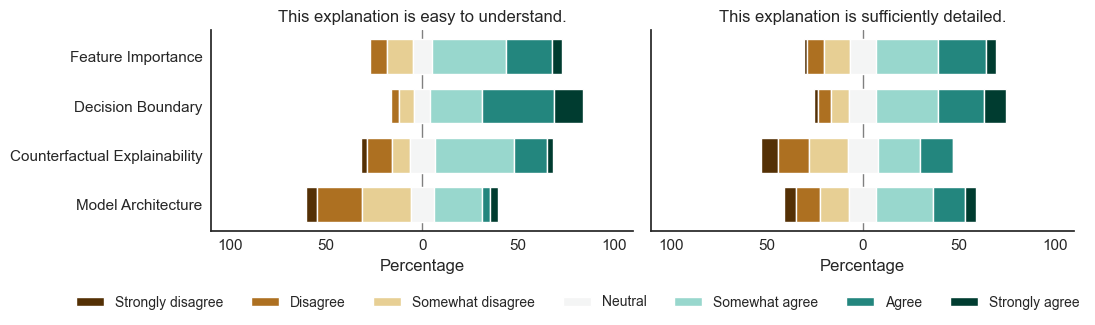

In [443]:
exp_categories = ["Feature Importance", "Decision Boundary", "Counterfactual Explainability", "Model Architecture"]
strongly_disagree = [exp1_c_response[1], exp2_c_response[1], exp3_c_response[1], exp4_c_response[1]]
disagree = [exp1_c_response[2], exp2_c_response[2], exp3_c_response[2], exp4_c_response[2]]
some_disagree = [exp1_c_response[3], exp2_c_response[3], exp3_c_response[3], exp4_c_response[3]]
neutral = [exp1_c_response[4], exp2_c_response[4], exp3_c_response[4], exp4_c_response[4]]
some_agree = [exp1_c_response[5], exp2_c_response[5], exp3_c_response[5], exp4_c_response[5]]
agree = [exp1_c_response[6], exp2_c_response[6], exp3_c_response[6], exp4_c_response[6]]
strongly_agree = [exp1_c_response[7], exp2_c_response[7], exp3_c_response[7], exp4_c_response[7]]

# Calculate the total count for each category
totals = np.array(strongly_disagree) + np.array(disagree) + np.array(some_disagree) + np.array(neutral) + np.array(some_agree) + np.array(agree) + np.array(strongly_agree)

# Normalize the data to get percentages
strongly_disagree_pct = np.array(strongly_disagree) / totals * 100
disagree_pct = np.array(disagree) / totals * 100
some_disagree_pct = np.array(some_disagree) / totals * 100
neutral_pct = np.array(neutral) / totals * 100
some_agree_pct = np.array(some_agree) / totals * 100
agree_pct = np.array(agree) / totals * 100
strongly_agree_pct = np.array(strongly_agree) / totals * 100

# Create a horizontal stacked bar plot
# with plt.style.context('default'):
fig, ax = plt.subplots(figsize=(11, 3), ncols=2)

bar_width = 0.7
index = np.arange(len(exp_categories))[::-1]
num_colors = 7
# Create a color gradient from red to green
colors = plt.cm.BrBG(np.linspace(0, 1, num_colors))

ax[0].barh(index, strongly_disagree_pct, bar_width,left=-neutral_pct/2-some_disagree_pct-disagree_pct-strongly_disagree_pct, label='Strongly Disagree', color=colors[0])
ax[0].barh(index, disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct-disagree_pct, label='Disagree', color=colors[1])
ax[0].barh(index, some_disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct, label='Some Disagree', color=colors[2])
# ax.barh(index, neutral_pct, bar_width, left=strongly_disagree_pct + disagree_pct + some_disagree_pct, label='Neutral')
ax[0].barh(index, neutral_pct, bar_width, left=-neutral_pct/2, label='Neutral',color=colors[3])
ax[0].barh(index, some_agree_pct, bar_width, left=neutral_pct/2, label='Some Agree', color=colors[4])
ax[0].barh(index, agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct, label='Agree', color=colors[5])
ax[0].barh(index, strongly_agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct + agree_pct, label='Strongly Agree', color=colors[6])

# ax.set_ylabel('Explanation Categories')
ax[0].set_xlabel('Percentage')
ax[0].set_title('This explanation is easy to understand.')
ax[0].set_yticks(index)
ax[0].set_yticklabels(exp_categories)
ax[0].set_xlim(-110, 110)
ax[0].set_xticks(np.arange(-100, 100.1, 50))
ax[0].set_xticklabels([100, 50, 0, 50, 100])

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', which='both', length=0, pad=6)
ax[0].axvline(x=0, zorder=0, color="grey", linewidth=1)



# exp_categories = ["Feature Importance", "Decision Boundary", "Counterfactual Explanation", "Transparent Model"]
strongly_disagree = [exp1_s_response[1], exp2_s_response[1], exp3_s_response[1], exp4_s_response[1]]
disagree = [exp1_s_response[2], exp2_s_response[2], exp3_s_response[2], exp4_s_response[2]]
some_disagree = [exp1_s_response[3], exp2_s_response[3], exp3_s_response[3], exp4_s_response[3]]
neutral = [exp1_s_response[4], exp2_s_response[4], exp3_s_response[4], exp4_s_response[4]]
some_agree = [exp1_s_response[5], exp2_s_response[5], exp3_s_response[5], exp4_s_response[5]]
agree = [exp1_s_response[6], exp2_s_response[6], exp3_s_response[6], exp4_s_response[6]]
strongly_agree = [exp1_s_response[7], exp2_s_response[7], exp3_s_response[7], exp4_s_response[7]]

# Calculate the total count for each category
totals = np.array(strongly_disagree) + np.array(disagree) + np.array(some_disagree) + np.array(neutral) + np.array(some_agree) + np.array(agree) + np.array(strongly_agree)

# Normalize the data to get percentages
strongly_disagree_pct = np.array(strongly_disagree) / totals * 100
disagree_pct = np.array(disagree) / totals * 100
some_disagree_pct = np.array(some_disagree) / totals * 100
neutral_pct = np.array(neutral) / totals * 100
some_agree_pct = np.array(some_agree) / totals * 100
agree_pct = np.array(agree) / totals * 100
strongly_agree_pct = np.array(strongly_agree) / totals * 100


ax[1].barh(index, strongly_disagree_pct, bar_width,left=-neutral_pct/2-some_disagree_pct-disagree_pct-strongly_disagree_pct, label='Strongly Disagree', color=colors[0])
ax[1].barh(index, disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct-disagree_pct, label='Disagree', color=colors[1])
ax[1].barh(index, some_disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct, label='Some Disagree', color=colors[2])
# ax.barh(index, neutral_pct, bar_width, left=strongly_disagree_pct + disagree_pct + some_disagree_pct, label='Neutral')
ax[1].barh(index, neutral_pct, bar_width, left=-neutral_pct/2, label='Neutral',color=colors[3])
ax[1].barh(index, some_agree_pct, bar_width, left=neutral_pct/2, label='Some Agree', color=colors[4])
ax[1].barh(index, agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct, label='Agree', color=colors[5])
ax[1].barh(index, strongly_agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct + agree_pct, label='Strongly Agree', color=colors[6])

# ax.set_ylabel('Explanation Categories')
ax[1].set_xlabel('Percentage')
ax[1].set_title('This explanation is sufficiently detailed.')
# ax.set_yticks(index)
# ax[1].set_yticklabels(exp_categories)
ax[1].yaxis.set_visible(False)
ax[1].set_xlim(-110, 110)
ax[1].set_xticks(np.arange(-100, 100.1, 50))
ax[1].set_xticklabels([100, 50, 0, 50, 100])

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].tick_params(axis='both', which='both', length=0, pad=6)
ax[1].axvline(x=0, zorder=0, color="grey", linewidth=1)


# legend_position = 'center right'
legend_bbox = (1, -0.1)  # Adjust the vertical position as needed
proxy = [plt.Rectangle((0,0),1,1, fc = colors[i]) for i in range(7)]
fig.legend(proxy, ["Strongly disagree", "Disagree", "Somewhat disagree", "Neutral", "Somewhat agree", "Agree", "Strongly agree"], loc="lower right", ncol=7, bbox_to_anchor=legend_bbox, fontsize=10, edgecolor="white")
plt.tight_layout()
plt.savefig("../figures/subjective_comp.pdf", dpi=300, transparent=True, bbox_inches="tight")
plt.show()


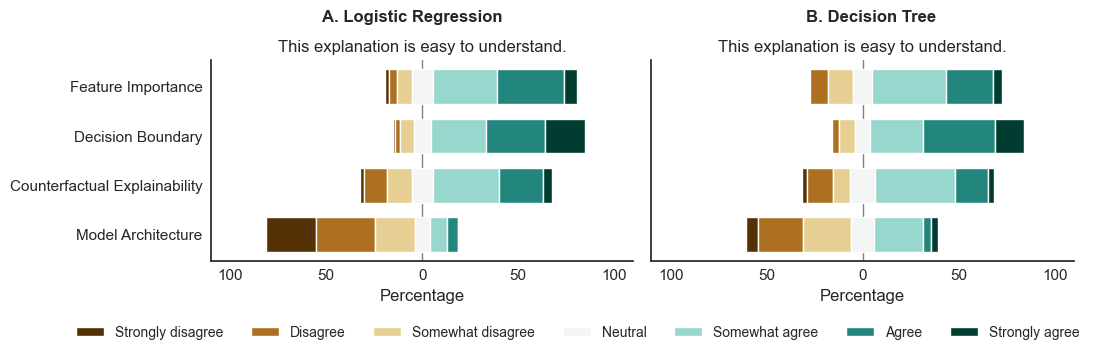

In [444]:
exp1_c_response = Counter([x for x in l1_c_response.tolist() if x == x])
exp2_c_response = Counter([x for x in l2_c_response.tolist() if x == x])
exp3_c_response = Counter([x for x in l3_c_response.tolist() if x == x])
exp4_c_response = Counter([x for x in l4_c_response.tolist() if x == x])

exp_categories = ["Feature Importance", "Decision Boundary", "Counterfactual Explainability", "Model Architecture"]
strongly_disagree = [exp1_c_response[1], exp2_c_response[1], exp3_c_response[1], exp4_c_response[1]]
disagree = [exp1_c_response[2], exp2_c_response[2], exp3_c_response[2], exp4_c_response[2]]
some_disagree = [exp1_c_response[3], exp2_c_response[3], exp3_c_response[3], exp4_c_response[3]]
neutral = [exp1_c_response[4], exp2_c_response[4], exp3_c_response[4], exp4_c_response[4]]
some_agree = [exp1_c_response[5], exp2_c_response[5], exp3_c_response[5], exp4_c_response[5]]
agree = [exp1_c_response[6], exp2_c_response[6], exp3_c_response[6], exp4_c_response[6]]
strongly_agree = [exp1_c_response[7], exp2_c_response[7], exp3_c_response[7], exp4_c_response[7]]

# Calculate the total count for each category
totals = np.array(strongly_disagree) + np.array(disagree) + np.array(some_disagree) + np.array(neutral) + np.array(some_agree) + np.array(agree) + np.array(strongly_agree)

# Normalize the data to get percentages
strongly_disagree_pct = np.array(strongly_disagree) / totals * 100
disagree_pct = np.array(disagree) / totals * 100
some_disagree_pct = np.array(some_disagree) / totals * 100
neutral_pct = np.array(neutral) / totals * 100
some_agree_pct = np.array(some_agree) / totals * 100
agree_pct = np.array(agree) / totals * 100
strongly_agree_pct = np.array(strongly_agree) / totals * 100

# Create a horizontal stacked bar plot
# with plt.style.context('default'):
fig, ax = plt.subplots(figsize=(11, 3), ncols=2)

bar_width = 0.7
index = np.arange(len(exp_categories))[::-1]
num_colors = 7
# Create a color gradient from red to green
colors = plt.cm.BrBG(np.linspace(0, 1, num_colors))

ax[0].barh(index, strongly_disagree_pct, bar_width,left=-neutral_pct/2-some_disagree_pct-disagree_pct-strongly_disagree_pct, label='Strongly Disagree', color=colors[0])
ax[0].barh(index, disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct-disagree_pct, label='Disagree', color=colors[1])
ax[0].barh(index, some_disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct, label='Some Disagree', color=colors[2])
# ax.barh(index, neutral_pct, bar_width, left=strongly_disagree_pct + disagree_pct + some_disagree_pct, label='Neutral')
ax[0].barh(index, neutral_pct, bar_width, left=-neutral_pct/2, label='Neutral',color=colors[3])
ax[0].barh(index, some_agree_pct, bar_width, left=neutral_pct/2, label='Some Agree', color=colors[4])
ax[0].barh(index, agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct, label='Agree', color=colors[5])
ax[0].barh(index, strongly_agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct + agree_pct, label='Strongly Agree', color=colors[6])

# ax.set_ylabel('Explanation Categories')
ax[0].set_xlabel('Percentage')
ax[0].set_title('This explanation is easy to understand.')
ax[0].set_yticks(index)
ax[0].set_yticklabels(exp_categories)
ax[0].set_xlim(-110, 110)
ax[0].set_xticks(np.arange(-100, 100.1, 50))
ax[0].set_xticklabels([100, 50, 0, 50, 100])

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', which='both', length=0, pad=6)
ax[0].axvline(x=0, zorder=0, color="grey", linewidth=1)


exp1_c_response = Counter([x for x in d1_c_response.tolist() if x == x])
exp2_c_response = Counter([x for x in d2_c_response.tolist() if x == x])
exp3_c_response = Counter([x for x in d3_c_response.tolist() if x == x])
exp4_c_response = Counter([x for x in d4_c_response.tolist() if x == x])

# exp_categories = ["Feature Importance", "Decision Boundary", "Counterfactual Explainability", "Transparent Modelling"]
strongly_disagree = [exp1_c_response[1], exp2_c_response[1], exp3_c_response[1], exp4_c_response[1]]
disagree = [exp1_c_response[2], exp2_c_response[2], exp3_c_response[2], exp4_c_response[2]]
some_disagree = [exp1_c_response[3], exp2_c_response[3], exp3_c_response[3], exp4_c_response[3]]
neutral = [exp1_c_response[4], exp2_c_response[4], exp3_c_response[4], exp4_c_response[4]]
some_agree = [exp1_c_response[5], exp2_c_response[5], exp3_c_response[5], exp4_c_response[5]]
agree = [exp1_c_response[6], exp2_c_response[6], exp3_c_response[6], exp4_c_response[6]]
strongly_agree = [exp1_c_response[7], exp2_c_response[7], exp3_c_response[7], exp4_c_response[7]]

# Calculate the total count for each category
totals = np.array(strongly_disagree) + np.array(disagree) + np.array(some_disagree) + np.array(neutral) + np.array(some_agree) + np.array(agree) + np.array(strongly_agree)

# Normalize the data to get percentages
strongly_disagree_pct = np.array(strongly_disagree) / totals * 100
disagree_pct = np.array(disagree) / totals * 100
some_disagree_pct = np.array(some_disagree) / totals * 100
neutral_pct = np.array(neutral) / totals * 100
some_agree_pct = np.array(some_agree) / totals * 100
agree_pct = np.array(agree) / totals * 100
strongly_agree_pct = np.array(strongly_agree) / totals * 100


ax[1].barh(index, strongly_disagree_pct, bar_width,left=-neutral_pct/2-some_disagree_pct-disagree_pct-strongly_disagree_pct, label='Strongly Disagree', color=colors[0])
ax[1].barh(index, disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct-disagree_pct, label='Disagree', color=colors[1])
ax[1].barh(index, some_disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct, label='Some Disagree', color=colors[2])
# ax.barh(index, neutral_pct, bar_width, left=strongly_disagree_pct + disagree_pct + some_disagree_pct, label='Neutral')
ax[1].barh(index, neutral_pct, bar_width, left=-neutral_pct/2, label='Neutral',color=colors[3])
ax[1].barh(index, some_agree_pct, bar_width, left=neutral_pct/2, label='Some Agree', color=colors[4])
ax[1].barh(index, agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct, label='Agree', color=colors[5])
ax[1].barh(index, strongly_agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct + agree_pct, label='Strongly Agree', color=colors[6])

# ax.set_ylabel('Explanation Categories')
ax[1].set_xlabel('Percentage')
ax[1].set_title('This explanation is easy to understand.')
# ax.set_yticks(index)
# ax[1].set_yticklabels(exp_categories)
ax[1].yaxis.set_visible(False)
ax[1].set_xlim(-110, 110)
ax[1].set_xticks(np.arange(-100, 100.1, 50))
ax[1].set_xticklabels([100, 50, 0, 50, 100])

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].tick_params(axis='both', which='both', length=0, pad=6)
ax[1].axvline(x=0, zorder=0, color="grey", linewidth=1)


# legend_position = 'center right'
legend_bbox = (1, -0.1)  # Adjust the vertical position as needed
proxy = [plt.Rectangle((0,0),1,1, fc = colors[i]) for i in range(7)]
fig.legend(proxy, ["Strongly disagree", "Disagree", "Somewhat disagree", "Neutral", "Somewhat agree", "Agree", "Strongly agree"], loc="lower right", ncol=7, bbox_to_anchor=legend_bbox, fontsize=10, edgecolor="white")

fig.text(0.3,1,"A. Logistic Regression", fontdict=dict(weight='bold'))
fig.text(0.74,1,"B. Decision Tree",fontdict=dict(weight='bold'))

plt.tight_layout()
plt.savefig("../figures/subjective_per_model.pdf", dpi=300, transparent=True, bbox_inches="tight")
plt.show()


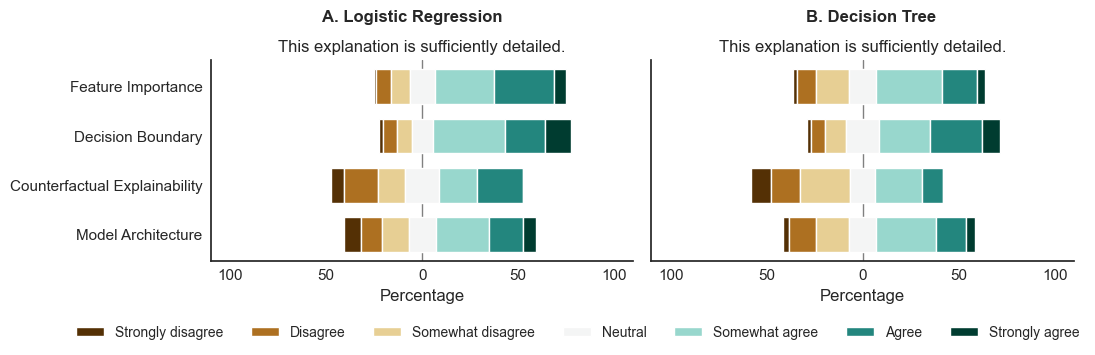

In [445]:
exp1_c_response = Counter([x for x in l1_s_response.tolist() if x == x])
exp2_c_response = Counter([x for x in l2_s_response.tolist() if x == x])
exp3_c_response = Counter([x for x in l3_s_response.tolist() if x == x])
exp4_c_response = Counter([x for x in l4_s_response.tolist() if x == x])

exp_categories = ["Feature Importance", "Decision Boundary", "Counterfactual Explainability", "Model Architecture"]
strongly_disagree = [exp1_c_response[1], exp2_c_response[1], exp3_c_response[1], exp4_c_response[1]]
disagree = [exp1_c_response[2], exp2_c_response[2], exp3_c_response[2], exp4_c_response[2]]
some_disagree = [exp1_c_response[3], exp2_c_response[3], exp3_c_response[3], exp4_c_response[3]]
neutral = [exp1_c_response[4], exp2_c_response[4], exp3_c_response[4], exp4_c_response[4]]
some_agree = [exp1_c_response[5], exp2_c_response[5], exp3_c_response[5], exp4_c_response[5]]
agree = [exp1_c_response[6], exp2_c_response[6], exp3_c_response[6], exp4_c_response[6]]
strongly_agree = [exp1_c_response[7], exp2_c_response[7], exp3_c_response[7], exp4_c_response[7]]

# Calculate the total count for each category
totals = np.array(strongly_disagree) + np.array(disagree) + np.array(some_disagree) + np.array(neutral) + np.array(some_agree) + np.array(agree) + np.array(strongly_agree)

# Normalize the data to get percentages
strongly_disagree_pct = np.array(strongly_disagree) / totals * 100
disagree_pct = np.array(disagree) / totals * 100
some_disagree_pct = np.array(some_disagree) / totals * 100
neutral_pct = np.array(neutral) / totals * 100
some_agree_pct = np.array(some_agree) / totals * 100
agree_pct = np.array(agree) / totals * 100
strongly_agree_pct = np.array(strongly_agree) / totals * 100

# Create a horizontal stacked bar plot
# with plt.style.context('default'):
fig, ax = plt.subplots(figsize=(11, 3), ncols=2)

bar_width = 0.7
index = np.arange(len(exp_categories))[::-1]
num_colors = 7
# Create a color gradient from red to green
colors = plt.cm.BrBG(np.linspace(0, 1, num_colors))

ax[0].barh(index, strongly_disagree_pct, bar_width,left=-neutral_pct/2-some_disagree_pct-disagree_pct-strongly_disagree_pct, label='Strongly Disagree', color=colors[0])
ax[0].barh(index, disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct-disagree_pct, label='Disagree', color=colors[1])
ax[0].barh(index, some_disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct, label='Some Disagree', color=colors[2])
# ax.barh(index, neutral_pct, bar_width, left=strongly_disagree_pct + disagree_pct + some_disagree_pct, label='Neutral')
ax[0].barh(index, neutral_pct, bar_width, left=-neutral_pct/2, label='Neutral',color=colors[3])
ax[0].barh(index, some_agree_pct, bar_width, left=neutral_pct/2, label='Some Agree', color=colors[4])
ax[0].barh(index, agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct, label='Agree', color=colors[5])
ax[0].barh(index, strongly_agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct + agree_pct, label='Strongly Agree', color=colors[6])

# ax.set_ylabel('Explanation Categories')
ax[0].set_xlabel('Percentage')
ax[0].set_title('This explanation is sufficiently detailed.')
ax[0].set_yticks(index)
ax[0].set_yticklabels(exp_categories)
ax[0].set_xlim(-110, 110)
ax[0].set_xticks(np.arange(-100, 100.1, 50))
ax[0].set_xticklabels([100, 50, 0, 50, 100])

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', which='both', length=0, pad=6)
ax[0].axvline(x=0, zorder=0, color="grey", linewidth=1)


exp1_c_response = Counter([x for x in d1_s_response.tolist() if x == x])
exp2_c_response = Counter([x for x in d2_s_response.tolist() if x == x])
exp3_c_response = Counter([x for x in d3_s_response.tolist() if x == x])
exp4_c_response = Counter([x for x in d4_s_response.tolist() if x == x])

# exp_categories = ["Feature Importance", "Decision Boundary", "Counterfactual Explainability", "Transparent Modelling"]
strongly_disagree = [exp1_c_response[1], exp2_c_response[1], exp3_c_response[1], exp4_c_response[1]]
disagree = [exp1_c_response[2], exp2_c_response[2], exp3_c_response[2], exp4_c_response[2]]
some_disagree = [exp1_c_response[3], exp2_c_response[3], exp3_c_response[3], exp4_c_response[3]]
neutral = [exp1_c_response[4], exp2_c_response[4], exp3_c_response[4], exp4_c_response[4]]
some_agree = [exp1_c_response[5], exp2_c_response[5], exp3_c_response[5], exp4_c_response[5]]
agree = [exp1_c_response[6], exp2_c_response[6], exp3_c_response[6], exp4_c_response[6]]
strongly_agree = [exp1_c_response[7], exp2_c_response[7], exp3_c_response[7], exp4_c_response[7]]

# Calculate the total count for each category
totals = np.array(strongly_disagree) + np.array(disagree) + np.array(some_disagree) + np.array(neutral) + np.array(some_agree) + np.array(agree) + np.array(strongly_agree)

# Normalize the data to get percentages
strongly_disagree_pct = np.array(strongly_disagree) / totals * 100
disagree_pct = np.array(disagree) / totals * 100
some_disagree_pct = np.array(some_disagree) / totals * 100
neutral_pct = np.array(neutral) / totals * 100
some_agree_pct = np.array(some_agree) / totals * 100
agree_pct = np.array(agree) / totals * 100
strongly_agree_pct = np.array(strongly_agree) / totals * 100


ax[1].barh(index, strongly_disagree_pct, bar_width,left=-neutral_pct/2-some_disagree_pct-disagree_pct-strongly_disagree_pct, label='Strongly Disagree', color=colors[0])
ax[1].barh(index, disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct-disagree_pct, label='Disagree', color=colors[1])
ax[1].barh(index, some_disagree_pct, bar_width, left=-neutral_pct/2-some_disagree_pct, label='Some Disagree', color=colors[2])
# ax.barh(index, neutral_pct, bar_width, left=strongly_disagree_pct + disagree_pct + some_disagree_pct, label='Neutral')
ax[1].barh(index, neutral_pct, bar_width, left=-neutral_pct/2, label='Neutral',color=colors[3])
ax[1].barh(index, some_agree_pct, bar_width, left=neutral_pct/2, label='Some Agree', color=colors[4])
ax[1].barh(index, agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct, label='Agree', color=colors[5])
ax[1].barh(index, strongly_agree_pct, bar_width, left=neutral_pct/2 + some_agree_pct + agree_pct, label='Strongly Agree', color=colors[6])

# ax.set_ylabel('Explanation Categories')
ax[1].set_xlabel('Percentage')
ax[1].set_title('This explanation is sufficiently detailed.')
# ax.set_yticks(index)
# ax[1].set_yticklabels(exp_categories)
ax[1].yaxis.set_visible(False)
ax[1].set_xlim(-110, 110)
ax[1].set_xticks(np.arange(-100, 100.1, 50))
ax[1].set_xticklabels([100, 50, 0, 50, 100])

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].tick_params(axis='both', which='both', length=0, pad=6)
ax[1].axvline(x=0, zorder=0, color="grey", linewidth=1)


# legend_position = 'center right'
legend_bbox = (1, -0.1)  # Adjust the vertical position as needed
proxy = [plt.Rectangle((0,0),1,1, fc = colors[i]) for i in range(7)]
fig.legend(proxy, ["Strongly disagree", "Disagree", "Somewhat disagree", "Neutral", "Somewhat agree", "Agree", "Strongly agree"], loc="lower right", ncol=7, bbox_to_anchor=legend_bbox, fontsize=10, edgecolor="white")

fig.text(0.3,1,"A. Logistic Regression", fontdict=dict(weight='bold'))
fig.text(0.74,1,"B. Decision Tree",fontdict=dict(weight='bold'))

plt.tight_layout()
plt.savefig("../figures/detailed_per_model.pdf", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

## ordering effect

In [138]:
dt_flow_order = {
    22: 1, 23: 2, 24: 3, 19: 4
}

lr_flow_order = {
    36: 1, 37: 2, 38: 3, 33: 4
}

dt_response_order = response_df["FL_18_DO"][2:].dropna()
lr_response_order = response_df["FL_32_DO"][2:].dropna()

all_score_order = []
model_first_score = []
for user_id, user_entry in dect_user_score.iterrows():
    split_order = dt_response_order[user_id+2].split('|')
    flow_order = [int(re.search(r'FL_(\d+)', item).group(1)) for item in split_order if re.search(r'FL_(\d+)', item)]
    num_order = [dt_flow_order[num] for num in flow_order]
    single_score = [user_entry["d{}_tf".format(i)] + user_entry["d{}_ct".format(i)] for i in num_order]
    all_score_order.append(single_score)
    if num_order[0] == 3:
        model_first_score.append(single_score)

for user_id, user_entry in logreg_user_score.iterrows():
    split_order = lr_response_order[user_id+2].split('|')
    flow_order = [int(re.search(r'FL_(\d+)', item).group(1)) for item in split_order if re.search(r'FL_(\d+)', item)]
    num_order = [lr_flow_order[num] for num in flow_order]
    single_score = [user_entry["l{}_tf".format(i)] + user_entry["l{}_ct".format(i)] for i in num_order]
    all_score_order.append(single_score)
    if num_order[0] == 0:
        model_first_score.append(single_score)
        

print(all_score_order)
print(model_first_score)

[[1.0, 0.0, 1.0, 2.0], [1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 0.0, 1.0], [1.0, 1.0, 1.0, 2.0], [1.0, 0.0, 0.0, 1.0], [1.0, 1.0, 1.0, 0.0], [2.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0], [1.0, 2.0, 1.0, 0.0], [2.0, 0.0, 0.0, 2.0], [0.0, 2.0, 1.0, 1.0], [1.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0], [1.0, 1.0, 1.0, 0.0], [2.0, 1.0, 1.0, 0.0], [2.0, 1.0, 1.0, 1.0], [2.0, 1.0, 2.0, 1.0], [2.0, 2.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [1.0, 1.0, 0.0, 0.0], [2.0, 1.0, 2.0, 2.0], [0.0, 1.0, 0.0, 0.0], [2.0, 2.0, 1.0, 2.0], [1.0, 2.0, 2.0, 1.0], [1.0, 1.0, 2.0, 1.0], [1.0, 1.0, 1.0, 1.0], [0.0, 2.0, 0.0, 2.0], [0.0, 0.0, 1.0, 1.0], [2.0, 0.0, 1.0, 2.0], [0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 2.0, 1.0], [2.0, 0.0, 2.0, 1.0], [2.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0], [1.0, 0.0, 1.0, 0.0], [1.0, 1.0, 1.0, 0.0], [0.0, 1.0, 1.0, 0.0], [0.0, 0.0, 1.0, 1.0], [2.0, 2.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0], [1.0, 0.0

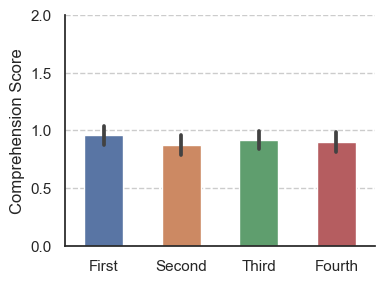

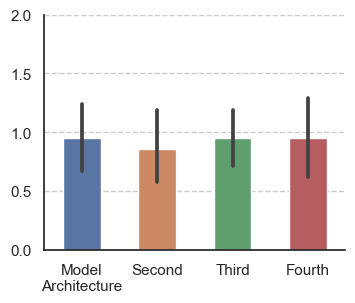

In [140]:
order_df = pd.DataFrame(all_score_order)

fig0, ax0 = plt.subplots(figsize=(4, 3))
fig1, ax1 = plt.subplots(figsize=(3.8, 3.2))

sns.barplot(order_df, errorbar="ci", width=0.5, ax=ax0)
ax0.set_xticklabels(["First", "Second", "Third", "Fourth"])
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.grid(linestyle="--", axis="y", zorder=-1)
ax0.set_ylabel("Comprehension Score")
# # ax.set_title("avg score (model explanation is random)")
ax0.set_ylim(0,2)

order_df = pd.DataFrame(model_first_score)

sns.barplot(order_df, errorbar="ci", width=0.5, ax=ax1)
ax1.set_xticklabels(["Model\nArchitecture", "Second", "Third", "Fourth"])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False) 
ax1.grid(linestyle="--", axis="y", zorder=-1)
ax1.set_ylim(0,2)
# ax.set_title("avg score (model explanation is the first)")

# fig.text(0.065,1,"A. Random Order", fontdict=dict(weight='bold'))
# fig.text(0.55,1,"B. Transparent Modelling as the First",fontdict=dict(weight='bold'))

plt.tight_layout()
fig0.savefig("../figures/priming_effect_0.pdf", dpi=300, transparent=True, bbox_inches="tight")
fig1.savefig("../figures/priming_effect_1.pdf", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

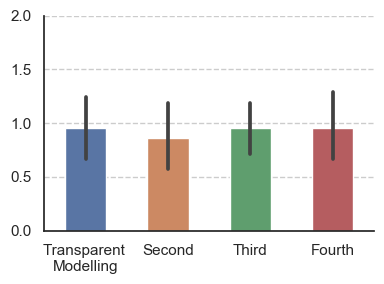

In [141]:
order_df = pd.DataFrame(model_first_score)

fig, ax = plt.subplots(figsize=(4,3))
ax = sns.barplot(order_df, errorbar="ci", width=0.5)
ax.set_xticklabels(["Model \nArchitecture", "Second", "Third", "Fourth"])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 
ax.grid(linestyle="--", axis="y", zorder=-1)
ax.set_ylim(0,2)
# ax.set_title("avg score (model explanation is the first)")
plt.tight_layout()
plt.savefig("../figures/model_exp_first.pdf", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [ ]:
# Sample continuous data (replace this with your data)
continuous_data = np.array([25.3, 30.1, 28.5, 26.8, 27.7, 29.2, 29.8, 31.4, 28.9, 29.7])

# Perform the Shapiro-Wilk test
statistic, p_value = stats.shapiro(continuous_data)

# Set significance level
alpha = 0.05

# Interpret the results
if p_value > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")



# Sample Likert scale data (replace this with your data)
likert_data = np.array([3, 4, 2, 3, 5, 4, 3, 2, 4, 3])

# Perform the Shapiro-Wilk test
statistic, p_value = stats.shapiro(likert_data)

# Set significance level
alpha = 0.05

# Interpret the results
if p_value > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")

